In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Ridge
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2

pd.options.display.max_columns= 82
pd.options.display.max_rows=82

# Useful functions

In [2]:
def grid_search(X, y, test_size=0.5, nruns=10, nalpha=100, log_alpha_min=-10, log_alpha_max=10):
    scaler = StandardScaler()
    gs_results = []    
    for run_idx in range(nruns):
        # Split into train/test sets
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=test_size, random_state=run_idx)
    
        # Standardize features
        X_tr_rescaled = scaler.fit_transform(X_tr)
        X_te_rescaled = scaler.transform(X_te)
            
        # Grid search
        for alpha in np.logspace(-10, 10, num=100):
            # Create and fit ridge regression
            ridge = Ridge(alpha=alpha)
            ridge.fit(X_tr_rescaled, y_tr)
        
            # Save model and its performance on train/test sets
            gs_results.append({
                'model': ridge,
                'alpha': alpha,
                'run_idx': run_idx,
                'train_mse': MSE(y_tr, ridge.predict(X_tr_rescaled)),
                'train_mae': MAE(np.exp(y_tr), np.exp(ridge.predict(X_tr_rescaled))),
                'train_r2': R2(y_tr, ridge.predict(X_tr_rescaled)),
                'test_mse': MSE(y_te, ridge.predict(X_te_rescaled)),
                'test_mae': MAE(np.exp(y_te), np.exp(ridge.predict(X_te_rescaled))),
                'test_r2': R2(y_te, ridge.predict(X_te_rescaled))
            })
    
    # Convert results to DataFrame
    return pd.DataFrame(gs_results)

In [3]:
def plot_ridge_score(gs_results):
    
    # Group results by alpha value
    gb_alpha = gs_results.groupby('alpha')
    
    # Compute train/test mean scores with std
    mean_tr = gb_alpha.train_mae.mean()
    mean_te = gb_alpha.test_mae.mean()
    std_tr = gb_alpha.train_mae.std()
    std_te = gb_alpha.test_mae.std()
    alphas = mean_tr.index.values
    
    # Get entry with the best mean test MSE
    best_alpha = mean_te.idxmin()
    
    # Plot mean scores
    plt.plot(np.log10(alphas), mean_tr, label='train')
    plt.plot(np.log10(alphas), mean_te, label='test')
    
    # Quantify variance with ±std curves
    plt.fill_between(np.log10(best_alpha), mean_tr-std_tr, mean_tr+std_tr, alpha=0.2)
    plt.fill_between(np.log10(alphas), mean_te-std_te, mean_te+std_te, alpha=0.2)
    
    # Add marker for best score
    plt.scatter(np.log10(best_alpha), mean_te.min(), marker='x', c='red', zorder=10)
    
    plt.title('Validation curves with {} runs'.format(len(gs_results.groupby('run_idx'))))
    plt.xlabel('$log_{10}(alpha)$')
    plt.ylabel('MAE ($)')
    plt.legend()
    plt.show()

# Read the data

In [4]:
df = pd.read_csv('house-prices-clean.csv', keep_default_na=False)
print(df.shape)
df.head()

(2925, 81)


,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,528275070,60,RL,0.0,8795,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,300.0,Unf,0.0,652.0,952.0,GasA,Ex,Y,SBrkr,980,1276,0,2256,0,0,2,1,4,1,Gd,8,Typ,1,TA,BuiltIn,2000,Fin,2,554.0,TA,TA,Y,224,54,0,0,0,0,NA,NA,NA,0,4,2009,WD,Normal,236000.0
1,535305120,20,RL,75.0,10170,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1951,1951,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,522.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,216.0,216.0,GasA,TA,Y,SBrkr,1575,0,0,1575,0,0,1,1,2,1,Gd,5,Typ,1,Gd,Attchd,1951,Unf,2,400.0,TA,TA,Y,0,0,0,0,0,0,NA,NA,NA,0,6,2006,WD,Normal,155000.0
2,923228250,160,RM,21.0,2001,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,BrkFace,80.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Fa,Y,SBrkr,546,546,0,1092,0,0,1,1,3,1,TA,6,Typ,0,NA,Attchd,1970,Unf,1,286.0,TA,TA,Y,0,0,0,0,0,0,NA,NA,NA,0,1,2007,WD,Normal,75000.0
3,535152150,20,RL,70.0,10552,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,5,1959,1959,Hip,CompShg,BrkFace,BrkFace,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,1018.0,Unf,0.0,380.0,1398.0,GasA,Gd,Y,SBrkr,1700,0,0,1700,0,1,1,1,4,1,Gd,6,Typ,1,Gd,Attchd,1959,RFn,2,447.0,TA,TA,Y,0,38,0,0,0,0,NA,NA,NA,0,4,2010,WD,Normal,165500.0
4,903475060,190,RM,60.0,10120,Pave,NA,IR1,Bnk,AllPub,Inside,Gtl,OldTown,Feedr,Norm,2fmCon,2.5Unf,7,4,1910,1950,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,925.0,925.0,GasA,TA,N,FuseF,964,925,0,1889,0,0,1,1,4,2,TA,9,Typ,1,Gd,Detchd,1960,Unf,1,308.0,TA,TA,N,0,0,264,0,0,0,NA,MnPrv,NA,0,1,2007,WD,Normal,122000.0


In [5]:
# columns with nominal values (23)
nominal_cols = [
    'MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour',
    'Lot Config', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style',
    'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation',
    'Heating', 'Central Air', 'Garage Type', 'Misc Feature', 'Sale Type', 'Sale Condition']

# columns with ordinal values (23)
ordinal_cols = [
    'Lot Shape', 'Utilities', 'Land Slope', 'Overall Qual', 'Overall Cond', 'Exter Qual',
    'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2',
    'Heating QC', 'Electrical', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Finish',
    'Garage Qual', 'Garage Cond', 'Paved Drive','Pool QC', 'Fence']

# columns with discrete values (14)
discrete_cols = [
    'Year Built', 'Year Remod/Add', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
    'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt',
    'Garage Cars', 'Mo Sold', 'Yr Sold']

# Continuous cols (20 including SalePrice)
continuous_cols = [
    'Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF',
    'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Garage Area',
    'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area',
    'Misc Val','SalePrice']

In [6]:
df['MS SubClass'] = df['MS SubClass'].astype(str)
df['Overall Qual'] = df['Overall Qual'].astype(str)
df['Overall Cond'] = df['Overall Cond'].astype(str)
df.loc[df[df.SalePrice == ''].index, 'SalePrice'] = np.NaN
df[continuous_cols] = df[continuous_cols].astype(float)
df[continuous_cols[:-1]] = df[continuous_cols[:-1]].astype(float)

In [7]:
df[continuous_cols].dtypes

Lot Frontage       float64
Lot Area           float64
Mas Vnr Area       float64
BsmtFin SF 1       float64
BsmtFin SF 2       float64
Bsmt Unf SF        float64
Total Bsmt SF      float64
1st Flr SF         float64
2nd Flr SF         float64
Low Qual Fin SF    float64
Gr Liv Area        float64
Garage Area        float64
Wood Deck SF       float64
Open Porch SF      float64
Enclosed Porch     float64
3Ssn Porch         float64
Screen Porch       float64
Pool Area          float64
Misc Val           float64
SalePrice          float64
dtype: object

# Change grades into discrete variables

In [8]:
# columns with ordinal values (23)
grade_cols = [
    'Overall Qual', 'Overall Cond', 'Exter Qual',
    'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2',
    'Heating QC', 'Kitchen Qual', 'Fireplace Qu', 'Garage Finish',
    'Garage Qual', 'Garage Cond', 'Pool QC', 'Fence']

In [9]:
dict_values = {
    'Ex': 5,
    'Gd': 4,
    'TA': 3,
    'Fa': 2,
    'Po': 1,
    'NA': 0,
    
    'Av': 3,
    'Mn': 2,
    'No': 1,
    
    'GLQ': 6,
    'ALQ': 5,
    'BLQ': 4,
    'Rec': 3,
    'LwQ': 2,
    'Unf': 1,
    
    'GdPrv': 4,
    'MnPrv': 3,
    'GdWo': 2,
    'MnWw': 1,
    
    'Fin': 3,
    'RFn': 2,
    'Unf': 1,
}

for col in grade_cols[2:]:
    df[col] = df[col].map(dict_values)
df[grade_cols[:2]] = df[grade_cols[:2]].astype(int)

In [10]:
df[grade_cols].dtypes

Overall Qual      int64
Overall Cond      int64
Exter Qual        int64
Exter Cond        int64
Bsmt Qual         int64
Bsmt Cond         int64
Bsmt Exposure     int64
BsmtFin Type 1    int64
BsmtFin Type 2    int64
Heating QC        int64
Kitchen Qual      int64
Fireplace Qu      int64
Garage Finish     int64
Garage Qual       int64
Garage Cond       int64
Pool QC           int64
Fence             int64
dtype: object

# One hot columns

In [11]:
# one hot ordinal cols
onehot_ordinal_cols = ['Lot Shape', 'Utilities', 'Land Slope', 'Electrical', 'Functional', 'Paved Drive']
onehot_cols = onehot_ordinal_cols.extend(nominal_cols)

encoded_df = pd.get_dummies(df, columns=onehot_cols)
print(encoded_df.shape)
encoded_df.head()

(2925, 267)


,PID,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating QC,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Fireplaces,Fireplace Qu,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Wood Deck SF,...,Electrical_Mix,Electrical_SBrkr,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Sev,Functional_Typ,Garage Type_2Types,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_NA,Paved Drive_N,Paved Drive_P,Paved Drive_Y,Misc Feature_Gar2,Misc Feature_NA,Misc Feature_Othr,Misc Feature_Shed,Misc Feature_TenC,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_Abnorml,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,528275070,0.0,8795.0,7,5,2000,2000,0.0,4,3,4,3,1,6,300.0,1,0.0,652.0,952.0,5,980.0,1276.0,0.0,2256.0,0,0,2,1,4,1,4,8,1,3,2000,3,2,554.0,3,3,224.0,...,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,535305120,75.0,10170.0,6,6,1951,1951,522.0,3,3,3,3,1,1,0.0,1,0.0,216.0,216.0,3,1575.0,0.0,0.0,1575.0,0,0,1,1,2,1,4,5,1,4,1951,1,2,400.0,3,3,0.0,...,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,923228250,21.0,2001.0,4,5,1970,1970,80.0,3,3,3,3,1,1,0.0,1,0.0,546.0,546.0,2,546.0,546.0,0.0,1092.0,0,0,1,1,3,1,3,6,0,0,1970,1,1,286.0,3,3,0.0,...,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,535152150,70.0,10552.0,5,5,1959,1959,0.0,3,3,3,3,1,3,1018.0,1,0.0,380.0,1398.0,4,1700.0,0.0,0.0,1700.0,0,1,1,1,4,1,4,6,1,4,1959,2,2,447.0,3,3,0.0,...,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,903475060,60.0,10120.0,7,4,1910,1950,0.0,2,3,3,3,1,1,0.0,1,0.0,925.0,925.0,3,964.0,925.0,0.0,1889.0,0,0,1,1,4,2,3,9,1,4,1960,1,1,308.0,3,3,0.0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


# Correlations

In [12]:
encoded_df[continuous_cols].corrwith(df.SalePrice).sort_values(ascending=False)

SalePrice          1.000000
Gr Liv Area        0.709232
Total Bsmt SF      0.664057
1st Flr SF         0.648286
Garage Area        0.639262
Mas Vnr Area       0.510379
BsmtFin SF 1       0.452527
Wood Deck SF       0.314765
Open Porch SF      0.309871
Lot Area           0.255283
2nd Flr SF         0.228232
Lot Frontage       0.189766
Bsmt Unf SF        0.182845
Screen Porch       0.124254
3Ssn Porch         0.040420
Pool Area          0.032426
BsmtFin SF 2       0.015116
Misc Val          -0.020813
Low Qual Fin SF   -0.030129
Enclosed Porch    -0.139432
dtype: float64

In [13]:
encoded_df[discrete_cols].corrwith(df.SalePrice).sort_values(ascending=False)

Garage Cars       0.648186
Year Built        0.567587
Garage Yr Blt     0.555758
Full Bath         0.549320
Year Remod/Add    0.536567
Fireplaces        0.492655
TotRms AbvGrd     0.485804
Bsmt Full Bath    0.276983
Half Bath         0.251787
Bedroom AbvGr     0.127078
Mo Sold           0.040900
Yr Sold          -0.023258
Bsmt Half Bath   -0.036675
Kitchen AbvGr    -0.121508
dtype: float64

In [14]:
encoded_df[grade_cols].corrwith(df.SalePrice).sort_values(ascending=False)

Overall Qual      0.804964
Exter Qual        0.706730
Kitchen Qual      0.674592
Bsmt Qual         0.607455
Garage Finish     0.553589
Fireplace Qu      0.553108
Heating QC        0.452187
Bsmt Exposure     0.416458
BsmtFin Type 1    0.347775
Garage Qual       0.287054
Garage Cond       0.269025
Bsmt Cond         0.213985
Pool QC           0.076084
BsmtFin Type 2    0.021102
Exter Cond        0.015204
Overall Cond     -0.103683
Fence            -0.169778
dtype: float64

In [15]:
encoded_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PID,2925.0,7.143948e+08,1.887292e+08,526301100.0,528477030.0,535453210.0,907181090.0,1.007100e+09
Lot Frontage,2925.0,5.747145e+01,3.309389e+01,0.0,43.0,63.0,78.0,3.130000e+02
Lot Area,2925.0,1.011526e+04,7.801349e+03,1300.0,7440.0,9430.0,11520.0,2.152450e+05
Overall Qual,2925.0,6.090256e+00,1.404285e+00,1.0,5.0,6.0,7.0,1.000000e+01
Overall Cond,2925.0,5.563077e+00,1.111993e+00,1.0,5.0,5.0,6.0,9.000000e+00
Year Built,2925.0,1.971287e+03,3.028081e+01,1872.0,1954.0,1973.0,2001.0,2.010000e+03
Year Remod/Add,2925.0,1.984254e+03,2.085679e+01,1950.0,1965.0,1993.0,2004.0,2.010000e+03
Mas Vnr Area,2925.0,1.001791e+02,1.759827e+02,0.0,0.0,0.0,162.0,1.600000e+03
Exter Qual,2925.0,3.396923e+00,5.783876e-01,2.0,3.0,3.0,4.0,5.000000e+00
Exter Cond,2925.0,3.085470e+00,3.719989e-01,1.0,3.0,3.0,3.0,5.000000e+00


# Training and test datasets

In [16]:
df_te = encoded_df[encoded_df.SalePrice.isna()].drop(columns='SalePrice')
print(df_te.shape)
df_tr = encoded_df[~encoded_df.SalePrice.isna()]
print(df_tr.shape)

(500, 266)
(2425, 267)


# Baseline

In [17]:
# Split into train-test subsets
X_baseline = df_tr.drop(columns='SalePrice').values
y_baseline = df_tr.SalePrice.values

X_tr_baseline, X_te_baseline, y_tr_baseline, y_te_baseline = train_test_split(X_baseline, y_baseline, test_size=0.5, random_state=0)

In [18]:
dummy = DummyRegressor(strategy='median')
dummy.fit(X_tr_baseline, y_tr_baseline)
y_pred_baseline = dummy.predict(X_te_baseline)

In [19]:
MSE_baseline_median = MSE(y_te_baseline, y_pred_baseline)
MAE_baseline_median = MAE(y_te_baseline, y_pred_baseline)
R2_baseline_median = R2(y_te_baseline, y_pred_baseline)
print('R2 baseline (median): {:.3f}'.format(R2_baseline_median))
print('MSE baseline (median): {:.3f}'.format(MSE_baseline_median))
print('MAE baseline (median): {:,.0f}$'.format(MAE_baseline_median))

R2 baseline (median): -0.064
MSE baseline (median): 6076824196.151
MAE baseline (median): 54,049$


# Simple model

Features selected: Gr Liv Area and Overall Qual since they have the best correlation and there is a value for each house

In [20]:
# Select the data from the train dataset
df_simple = df_tr[['Gr Liv Area', 'Overall Qual', 'SalePrice']]
df_simple.head()

,Gr Liv Area,Overall Qual,SalePrice
0,2256.0,7,236000.0
1,1575.0,6,155000.0
2,1092.0,4,75000.0
3,1700.0,5,165500.0
4,1889.0,7,122000.0


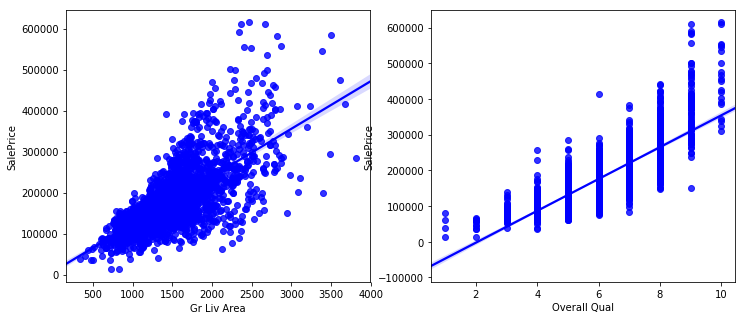

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
for i, col in enumerate(df_simple.columns[:2]):
    sns.regplot(x=col, y='SalePrice', data=df_simple, ax=axes[i], color='b')
plt.show()

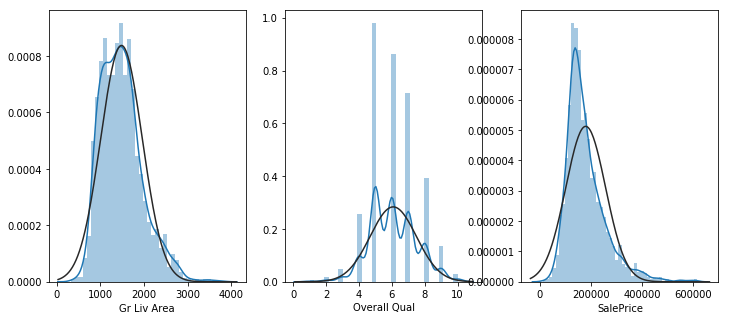

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
for i, col in enumerate(df_simple):
    sns.distplot(df_simple[col], fit=norm, ax=axes[i])
plt.show()

In [23]:
# log-transform data
simple_log_cols = ['Gr Liv Area', 'SalePrice']
df_simple = df_simple.apply(lambda x: np.log1p(x) if x.name in simple_log_cols else x)

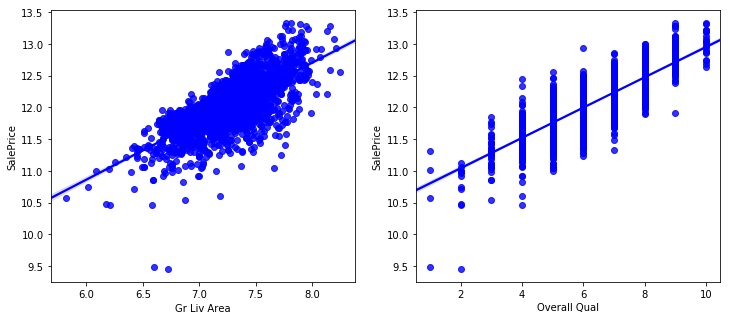

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
for i, col in enumerate(df_simple.columns[:2]):
    sns.regplot(x=col, y='SalePrice', data=df_simple, ax=axes[i], color='b')
plt.show()

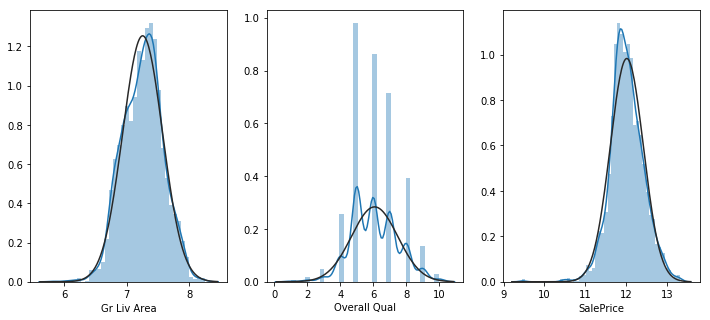

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
for i, col in enumerate(df_simple):
    sns.distplot(df_simple[col], fit=norm, ax=axes[i])
plt.show()

In [26]:
# Remove the two obvious outliers
ind_outlier = df_simple[df_simple.SalePrice < 10].index
df_simple.drop(index=ind_outlier, inplace=True)

In [27]:
X_simple = df_simple[['Gr Liv Area', 'Overall Qual']].values
y_simple = df_simple.SalePrice.values

# Split into train-test subsets
X_tr_simple, X_te_simple, y_tr_simple, y_te_simple = train_test_split(X_simple, y_simple, test_size=0.5, random_state=0)

In [28]:
# There are a couple of values that could be considered outliers so better use Huber loss regression
huber_simple = HuberRegressor()
huber_simple.fit(X_tr_simple, y_tr_simple)
y_pred_simple = huber_simple.predict(X_te_simple)

In [29]:
# Model evaluation
MSE_huber_simple = MSE(y_te_simple, y_pred_simple)
MAE_huber_simple = MAE(np.exp(y_te_simple), np.exp(y_pred_simple))
R2_huber_simple = R2(y_te_simple, y_pred_simple)
print('R2 huber simple: {:.3f}'.format(R2_huber_simple))
print('MSE huber simple: {:.3f}'.format(MSE_huber_simple))
print('MAE huber simple: {:,.0f}$'.format(MAE_huber_simple))

R2 huber simple: 0.763
MSE huber simple: 0.038
MAE huber simple: 24,968$


## Predictions

In [30]:
# Select the data from the train dataset
df_simple_te = df_te[['PID', 'Gr Liv Area', 'Overall Qual']]
df_simple_te.head()

,PID,Gr Liv Area,Overall Qual
2425,909279080,1991.0,6
2426,907126050,990.0,5
2427,528144030,1970.0,8
2428,535452060,1134.0,5
2429,911202100,1178.0,4


In [31]:
# log-transform data
simple_log_cols = ['Gr Liv Area']
df_simple_te = df_simple_te.apply(lambda x: np.log1p(x) if x.name in simple_log_cols else x)
df_simple_te.head()

,PID,Gr Liv Area,Overall Qual
2425,909279080,7.596894,6
2426,907126050,6.898715,5
2427,528144030,7.586296,8
2428,535452060,7.034388,5
2429,911202100,7.072422,4


In [32]:
X_simple_te = df_simple_te.drop(columns='PID').values
y_simple_pred = np.exp(huber_simple.predict(X_simple_te))

In [33]:
df_simple_te['SalePrice'] = y_simple_pred.astype(int)
df_simple_te.head()

,PID,Gr Liv Area,Overall Qual,SalePrice
2425,909279080,7.596894,6,192722
2426,907126050,6.898715,5,119059
2427,528144030,7.586296,8,272286
2428,535452060,7.034388,5,126366
2429,911202100,7.072422,4,107851


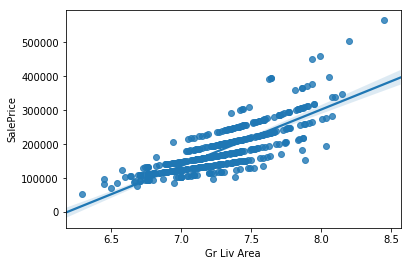

In [34]:
sns.regplot(x='Gr Liv Area', y='SalePrice', data=df_simple_te)
plt.show()

In [35]:
df_simple_te.drop(columns=['Gr Liv Area', 'Overall Qual'], inplace=True)
df_simple_te.to_csv('predictions-simple-model.csv', index=False)

# Intermediate model

We use either data that has a high correlation between feature and sale price or, in the case of categorical data, data where according to boxplots the categories are reasonably separable and have several features (more information content) 

In [36]:
# Select the columns
inter_numerical_cols = [
    'Gr Liv Area', '1st Flr SF', 'Full Bath',
    'Overall Qual', 'Exter Qual', 'Kitchen Qual', 'Bsmt Qual', 'Garage Finish',
    'Total Bsmt SF', 'Garage Area', 
    'Year Built', 'Year Remod/Add', 'Garage Yr Blt']

inter_cols = inter_numerical_cols.copy()

onehot_inter_cols = ['Lot Shape', 'Land Slope', 'Paved Drive', 'MS SubClass', 'Neighborhood']

encoded_cols = encoded_df.columns

for col in onehot_inter_cols:
    col_aux = encoded_cols[encoded_cols.str.contains(col)]
    inter_cols.extend(col_aux)
inter_cols.append('SalePrice')

In [37]:
# Select the data from the train dataset
df_inter = df_tr[inter_cols]
df_inter.head()

,Gr Liv Area,1st Flr SF,Full Bath,Overall Qual,Exter Qual,Kitchen Qual,Bsmt Qual,Garage Finish,Total Bsmt SF,Garage Area,Year Built,Year Remod/Add,Garage Yr Blt,Lot Shape_IR1,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Land Slope_Gtl,Land Slope_Mod,Land Slope_Sev,Paved Drive_N,Paved Drive_P,Paved Drive_Y,MS SubClass_120,MS SubClass_150,MS SubClass_160,MS SubClass_180,MS SubClass_190,MS SubClass_20,MS SubClass_30,MS SubClass_40,MS SubClass_45,MS SubClass_50,MS SubClass_60,MS SubClass_70,MS SubClass_75,MS SubClass_80,MS SubClass_85,MS SubClass_90,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,SalePrice
0,2256.0,980.0,2,7,4,4,4,3,952.0,554.0,2000,2000,2000,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,236000.0
1,1575.0,1575.0,1,6,3,4,3,1,216.0,400.0,1951,1951,1951,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,155000.0
2,1092.0,546.0,1,4,3,3,3,1,546.0,286.0,1970,1970,1970,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,75000.0
3,1700.0,1700.0,1,5,3,4,3,2,1398.0,447.0,1959,1959,1959,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,165500.0
4,1889.0,964.0,1,7,2,3,3,1,925.0,308.0,1910,1950,1960,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,122000.0


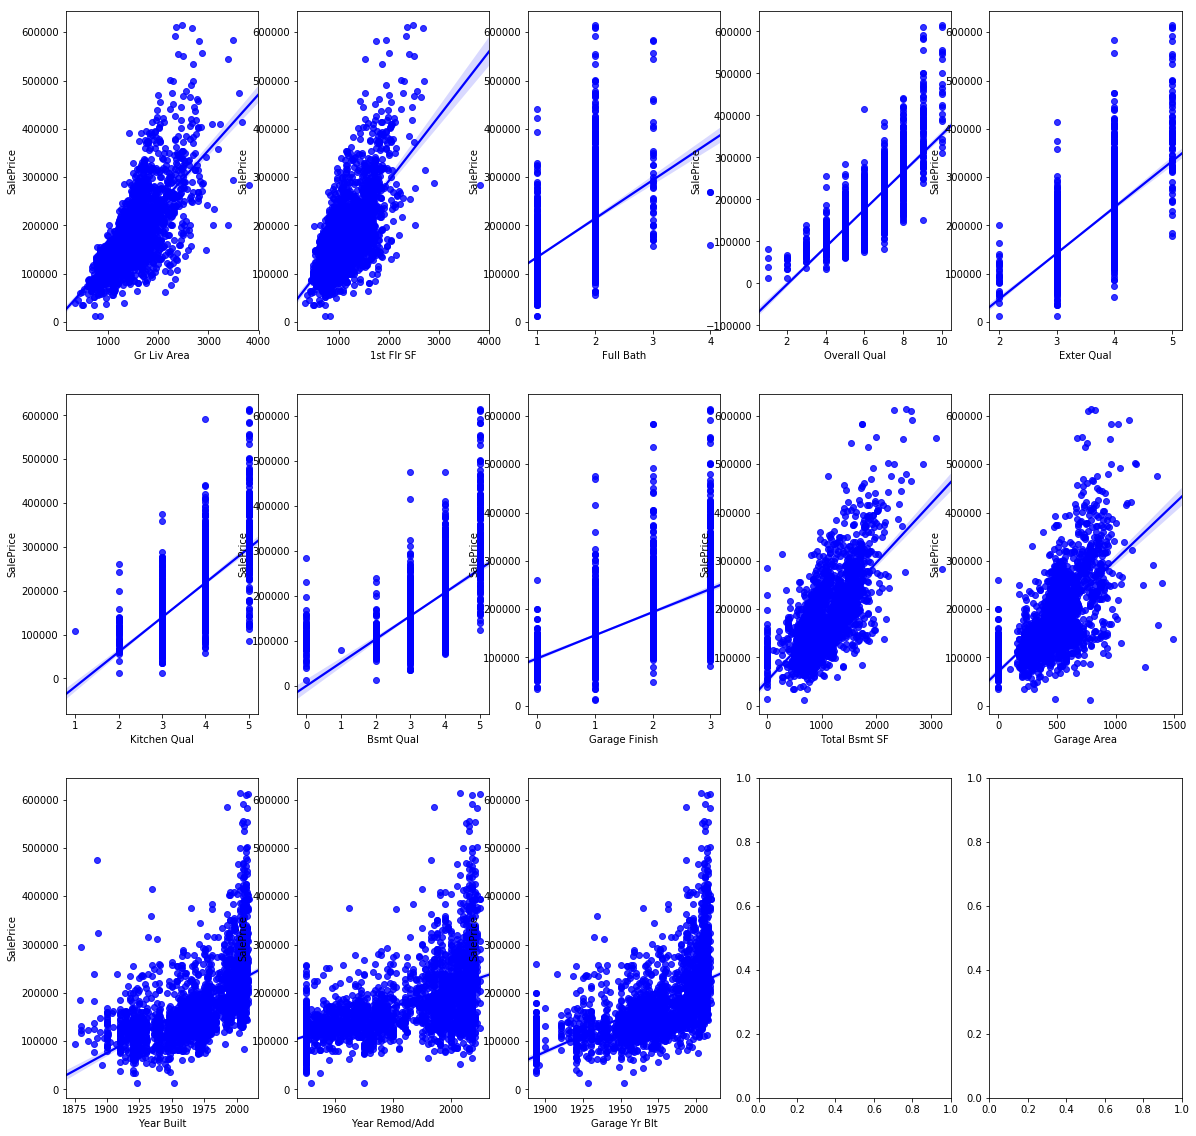

In [38]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20,20))
for i, col in enumerate(inter_numerical_cols):
    sns.regplot(x=col, y='SalePrice', data=df_inter, ax=axes[int(i/5), i%5], color='b')
plt.show()

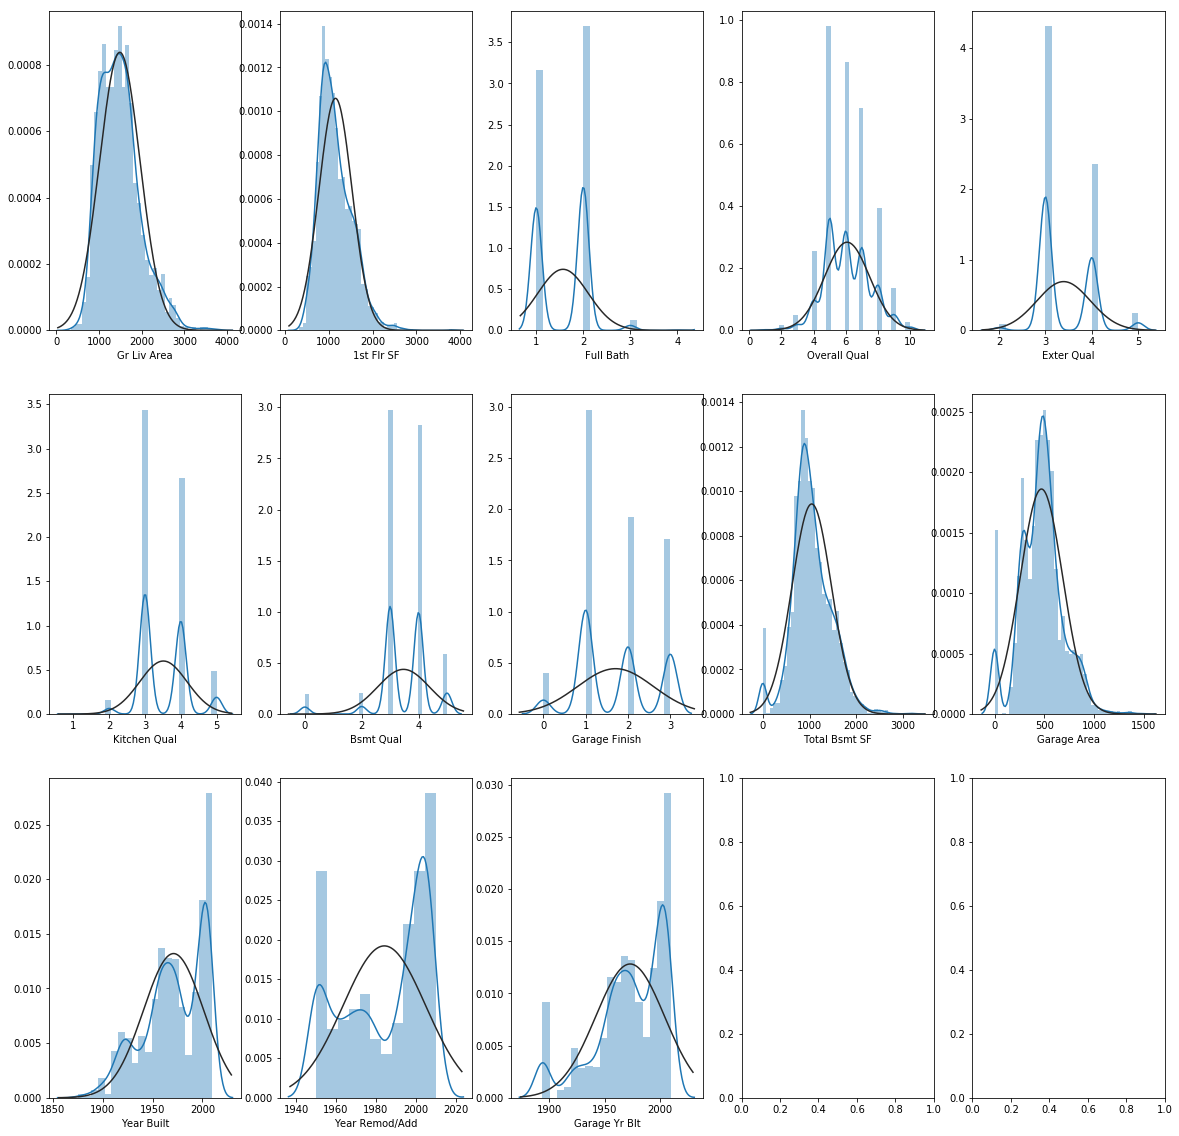

In [39]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20,20))
for i, col in enumerate(inter_numerical_cols):
    sns.distplot(df_inter[col], fit=norm, ax=axes[int(i/5), i%5])
plt.show()

In [40]:
# log-transform the data
inter_log_cols = ['1st Flr SF', 'Garage Area', 'Gr Liv Area', 'Total Bsmt SF', 'SalePrice']
df_inter = df_inter.apply(lambda x: np.log1p(x) if x.name in inter_log_cols else x)

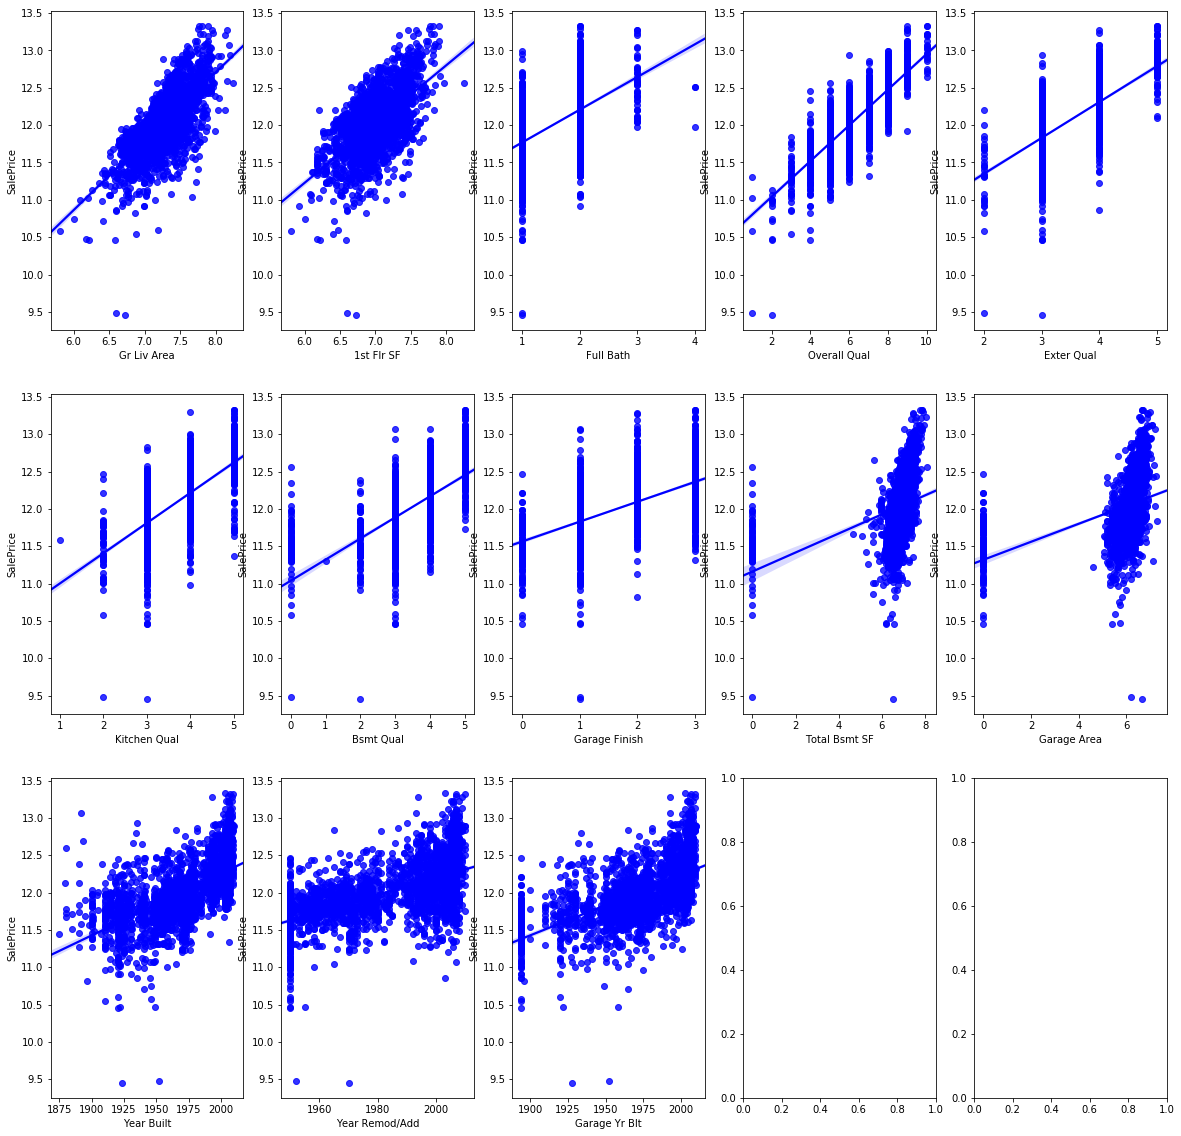

In [41]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20,20))
for i, col in enumerate(inter_numerical_cols):
    sns.regplot(x=col, y='SalePrice', data=df_inter, ax=axes[int(i/5), i%5], color='b')
plt.show()

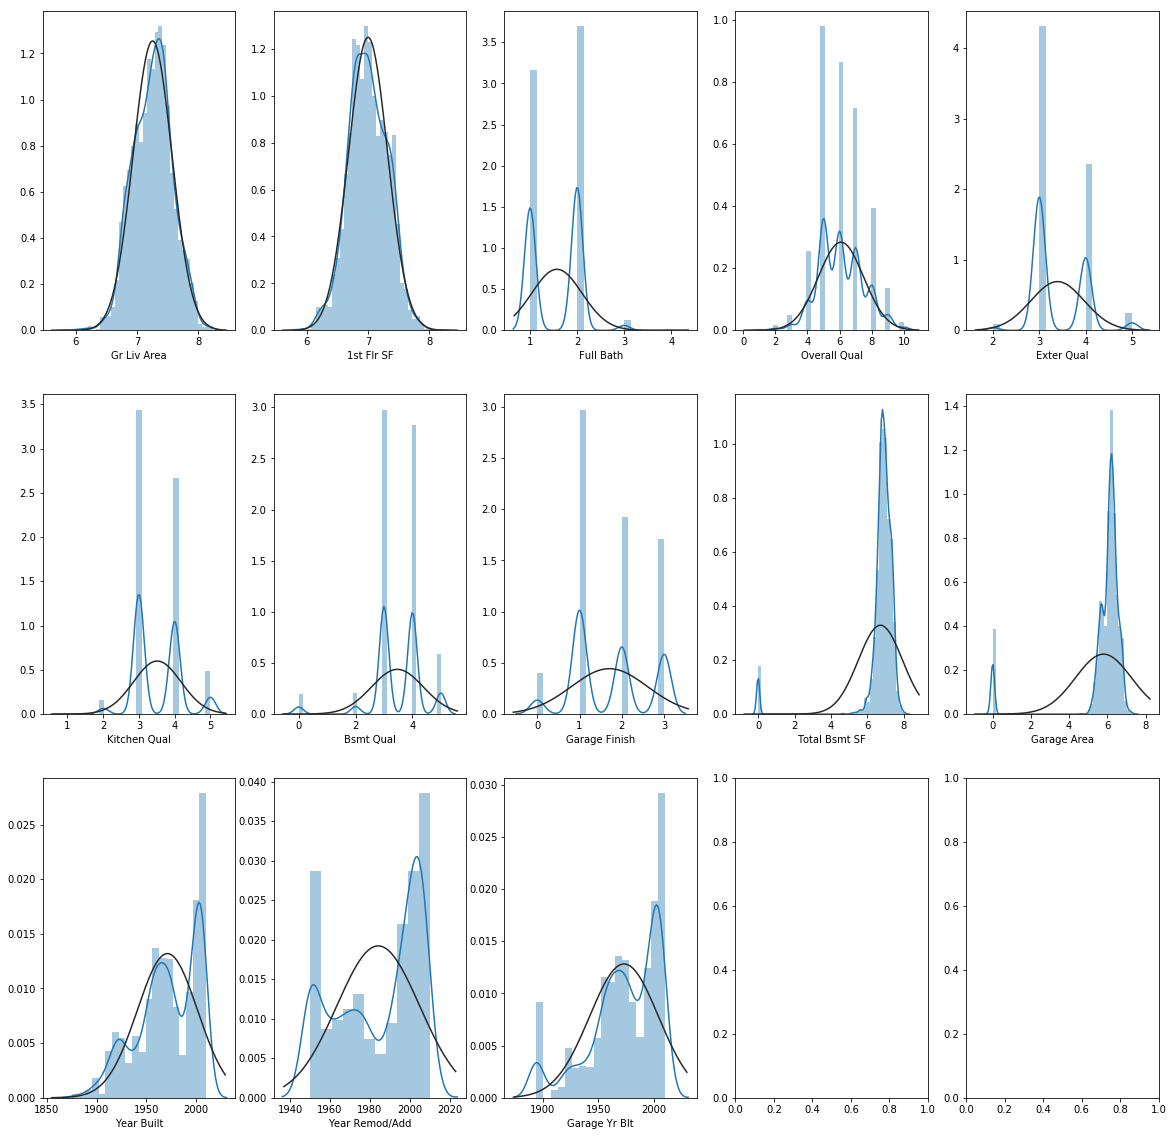

In [42]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20,20))
for i, col in enumerate(inter_numerical_cols):
    sns.distplot(df_inter[col], fit=norm, ax=axes[int(i/5), i%5])
plt.show()

In [43]:
# Remove the two obvious outliers
ind_outlier = df_inter[df_inter.SalePrice < 10].index
df_inter.drop(index=ind_outlier, inplace=True)

In [44]:
# Add variables basement exist and garage exists
df_inter['Basement exists'] = (df_inter['Total Bsmt SF'] > 0.).astype(int)
df_inter['Garage exists'] = (df_inter['Garage Area'] > 0.).astype(int)

In [45]:
X_inter = df_inter.drop(columns='SalePrice').values
y_inter = df_inter.SalePrice.values

# Split into train-test subsets
X_tr_inter, X_te_inter, y_tr_inter, y_te_inter = train_test_split(X_inter, y_inter, test_size=0.5, random_state=0)

In [46]:
# Rescale the data
scaler = StandardScaler()
X_tr_inter_rescaled = scaler.fit_transform(X_tr_inter)
X_te_inter_rescaled = scaler.transform(X_te_inter)

In [47]:
# There are a couple of values that could be considered outliers so better use Huber loss regression
huber_inter = HuberRegressor()
huber_inter.fit(X_tr_inter_rescaled, y_tr_inter)
y_pred_inter = huber_inter.predict(X_te_inter_rescaled)

In [48]:
# Model evaluation
MSE_huber_inter = MSE(y_te_inter, y_pred_inter)
MAE_huber_inter = MAE(np.exp(y_te_inter), np.exp(y_pred_inter))
R2_huber_inter = R2(y_te_inter, y_pred_inter)
print('R2 huber inter: {:.3f}'.format(R2_huber_inter))
print('MSE huber intermediate: {:.3f}'.format(MSE_huber_inter))
print('MAE huber intermediate: {:,.0f}$'.format(MAE_huber_inter))

R2 huber inter: 0.880
MSE huber intermediate: 0.019
MAE huber intermediate: 16,704$


## Ridge regression Intermediate model

In [49]:
gs_inter_results = grid_search(X_inter, y_inter, test_size=0.5, nruns=10, nalpha=100, log_alpha_min=-10, log_alpha_max=10)
gs_inter_results.head()

,alpha,model,run_idx,test_mae,test_mse,test_r2,train_mae,train_mse,train_r2
0,1.000000e-10,"Ridge(alpha=1e-10, copy_X=True, fit_intercept=...",0,16863.999244,0.019075,0.880877,16113.071425,0.015301,0.903611
1,1.592283e-10,"Ridge(alpha=1.592282793341094e-10, copy_X=True...",0,16864.093347,0.019076,0.880876,16113.071425,0.015301,0.903611
2,2.535364e-10,"Ridge(alpha=2.5353644939701164e-10, copy_X=Tru...",0,16864.124327,0.019076,0.880875,16113.071425,0.015301,0.903611
3,4.037017e-10,"Ridge(alpha=4.03701725859655e-10, copy_X=True,...",0,16864.180342,0.019076,0.880875,16113.071425,0.015301,0.903611
4,6.428073e-10,"Ridge(alpha=6.428073117284319e-10, copy_X=True...",0,16864.200933,0.019076,0.880874,16113.071425,0.015301,0.903611


In [50]:
# Group results by alpha value
gb_alpha = gs_inter_results.groupby('alpha')

# Compute test mean test scores
mean_te = gb_alpha.test_mae.mean()

# Get entry with the best mean test MAE
best_alpha_inter = mean_te.idxmin()
best_result_inter = gb_alpha.get_group(best_alpha_inter)
ind_best_run = best_result_inter[best_result_inter.test_mae == best_result_inter.test_mae.min()].index
best_run_inter = best_result_inter.loc[ind_best_run, 'run_idx'].values[0]

MSE_Ridge_inter = best_result_inter.loc[ind_best_run, 'test_mse'].values[0]
MAE_Ridge_inter = best_result_inter.loc[ind_best_run, 'test_mae'].values[0]
R2_Ridge_inter = best_result_inter.loc[ind_best_run, 'test_r2'].values[0]

# Print the details
print('Best alpha Ridge Intermediate: {:.1e}'.format(best_alpha_inter))
print('Best run Ridge Intermediate: {}'.format(best_run_inter))
print('Best R2 Ridge Intermediate: {:.3f}'.format(R2_Ridge_inter))
print('Best MSE Ridge Intermediate: {:.3f}'.format(MSE_Ridge_inter))
print('Best MAE Ridge Intermediate: {:,.0f}$'.format(MAE_Ridge_inter))

Best alpha Ridge Intermediate: 1.0e-10
Best run Ridge Intermediate: 8
Best R2 Ridge Intermediate: 0.879
Best MSE Ridge Intermediate: 0.019
Best MAE Ridge Intermediate: 16,484$


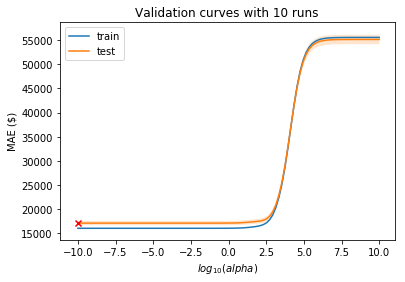

In [51]:
plot_ridge_score(gs_inter_results)

A very small alpha leads to the best results. The model does not need regularization.

## Predictions

In [52]:
# Select the data from the train dataset
df_inter_te = df_te[['PID']+inter_cols[:-1]]
df_inter_te.head()

,PID,Gr Liv Area,1st Flr SF,Full Bath,Overall Qual,Exter Qual,Kitchen Qual,Bsmt Qual,Garage Finish,Total Bsmt SF,Garage Area,Year Built,Year Remod/Add,Garage Yr Blt,Lot Shape_IR1,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Land Slope_Gtl,Land Slope_Mod,Land Slope_Sev,Paved Drive_N,Paved Drive_P,Paved Drive_Y,MS SubClass_120,MS SubClass_150,MS SubClass_160,MS SubClass_180,MS SubClass_190,MS SubClass_20,MS SubClass_30,MS SubClass_40,MS SubClass_45,MS SubClass_50,MS SubClass_60,MS SubClass_70,MS SubClass_75,MS SubClass_80,MS SubClass_85,MS SubClass_90,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
2425,909279080,1991.0,1096.0,1,6,3,3,3,1,854.0,432.0,1932,1950,1977,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2426,907126050,990.0,990.0,1,5,3,3,3,2,990.0,440.0,1994,1994,1995,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2427,528144030,1970.0,1120.0,2,8,4,5,4,3,1085.0,753.0,2006,2006,2006,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2428,535452060,1134.0,1134.0,1,5,3,3,3,2,1010.0,254.0,1960,2002,1960,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2429,911202100,1178.0,859.0,1,4,3,3,3,2,859.0,384.0,1900,1950,1964,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [53]:
# log-transform data
df_inter_te = df_inter_te.apply(lambda x: np.log1p(x) if x.name in inter_log_cols else x)
df_inter_te.head()

,PID,Gr Liv Area,1st Flr SF,Full Bath,Overall Qual,Exter Qual,Kitchen Qual,Bsmt Qual,Garage Finish,Total Bsmt SF,Garage Area,Year Built,Year Remod/Add,Garage Yr Blt,Lot Shape_IR1,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Land Slope_Gtl,Land Slope_Mod,Land Slope_Sev,Paved Drive_N,Paved Drive_P,Paved Drive_Y,MS SubClass_120,MS SubClass_150,MS SubClass_160,MS SubClass_180,MS SubClass_190,MS SubClass_20,MS SubClass_30,MS SubClass_40,MS SubClass_45,MS SubClass_50,MS SubClass_60,MS SubClass_70,MS SubClass_75,MS SubClass_80,MS SubClass_85,MS SubClass_90,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
2425,909279080,7.596894,7.000334,1,6,3,3,3,1,6.751101,6.070738,1932,1950,1977,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2426,907126050,6.898715,6.898715,1,5,3,3,3,2,6.898715,6.089045,1994,1994,1995,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2427,528144030,7.586296,7.021976,2,8,4,5,4,3,6.990257,6.625392,2006,2006,2006,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2428,535452060,7.034388,7.034388,1,5,3,3,3,2,6.918695,5.541264,1960,2002,1960,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2429,911202100,7.072422,6.756932,1,4,3,3,3,2,6.756932,5.953243,1900,1950,1964,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [54]:
# Add variables basement exist and garage exists
df_inter_te['Basement exists'] = (df_inter_te['Total Bsmt SF'] > 0.).astype(int)
df_inter_te['Garage exists'] = (df_inter_te['Garage Area'] > 0.).astype(int)

In [55]:
X_inter_te = df_inter_te.drop(columns='PID').values

In [56]:
# Split into train/test sets
X_tr, _, y_tr, _ = train_test_split(X_inter, y_inter, test_size=0.5, random_state=best_run_inter)
    
# Standardize features
X_tr_rescaled = scaler.fit_transform(X_tr)
X_te_rescaled = scaler.transform(X_inter_te)

ridge = Ridge(alpha=best_alpha_inter)
ridge.fit(X_tr_rescaled, y_tr)
y_inter_pred = np.exp(ridge.predict(X_te_rescaled))

In [57]:
df_inter_te['SalePrice'] = y_inter_pred.astype(int)
df_inter_te.head()

,PID,Gr Liv Area,1st Flr SF,Full Bath,Overall Qual,Exter Qual,Kitchen Qual,Bsmt Qual,Garage Finish,Total Bsmt SF,Garage Area,Year Built,Year Remod/Add,Garage Yr Blt,Lot Shape_IR1,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Land Slope_Gtl,Land Slope_Mod,Land Slope_Sev,Paved Drive_N,Paved Drive_P,Paved Drive_Y,MS SubClass_120,MS SubClass_150,MS SubClass_160,MS SubClass_180,MS SubClass_190,MS SubClass_20,MS SubClass_30,MS SubClass_40,MS SubClass_45,MS SubClass_50,MS SubClass_60,MS SubClass_70,MS SubClass_75,MS SubClass_80,MS SubClass_85,MS SubClass_90,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Basement exists,Garage exists,SalePrice
2425,909279080,7.596894,7.000334,1,6,3,3,3,1,6.751101,6.070738,1932,1950,1977,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,204479
2426,907126050,6.898715,6.898715,1,5,3,3,3,2,6.898715,6.089045,1994,1994,1995,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,144892
2427,528144030,7.586296,7.021976,2,8,4,5,4,3,6.990257,6.625392,2006,2006,2006,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,302569
2428,535452060,7.034388,7.034388,1,5,3,3,3,2,6.918695,5.541264,1960,2002,1960,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,139216
2429,911202100,7.072422,6.756932,1,4,3,3,3,2,6.756932,5.953243,1900,1950,1964,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,93275


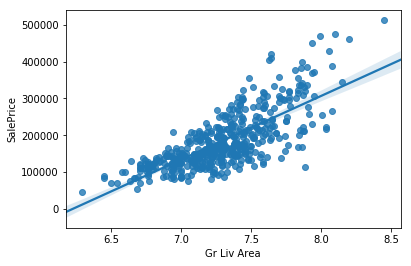

In [58]:
sns.regplot(x='Gr Liv Area', y='SalePrice', data=df_inter_te)
plt.show()

In [59]:
df_inter_te = df_inter_te[['PID', 'SalePrice']]
df_simple_te.to_csv('predictions-intermediate-model.csv', index=False)

# Complex model

In [60]:
# Select the data from the train dataset
df_complex = df_tr.copy()
print(df_complex.shape)
df_complex.head()

(2425, 267)


,PID,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating QC,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Fireplaces,Fireplace Qu,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Wood Deck SF,...,Electrical_Mix,Electrical_SBrkr,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Sev,Functional_Typ,Garage Type_2Types,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_NA,Paved Drive_N,Paved Drive_P,Paved Drive_Y,Misc Feature_Gar2,Misc Feature_NA,Misc Feature_Othr,Misc Feature_Shed,Misc Feature_TenC,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_Abnorml,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,528275070,0.0,8795.0,7,5,2000,2000,0.0,4,3,4,3,1,6,300.0,1,0.0,652.0,952.0,5,980.0,1276.0,0.0,2256.0,0,0,2,1,4,1,4,8,1,3,2000,3,2,554.0,3,3,224.0,...,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,535305120,75.0,10170.0,6,6,1951,1951,522.0,3,3,3,3,1,1,0.0,1,0.0,216.0,216.0,3,1575.0,0.0,0.0,1575.0,0,0,1,1,2,1,4,5,1,4,1951,1,2,400.0,3,3,0.0,...,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,923228250,21.0,2001.0,4,5,1970,1970,80.0,3,3,3,3,1,1,0.0,1,0.0,546.0,546.0,2,546.0,546.0,0.0,1092.0,0,0,1,1,3,1,3,6,0,0,1970,1,1,286.0,3,3,0.0,...,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,535152150,70.0,10552.0,5,5,1959,1959,0.0,3,3,3,3,1,3,1018.0,1,0.0,380.0,1398.0,4,1700.0,0.0,0.0,1700.0,0,1,1,1,4,1,4,6,1,4,1959,2,2,447.0,3,3,0.0,...,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,903475060,60.0,10120.0,7,4,1910,1950,0.0,2,3,3,3,1,1,0.0,1,0.0,925.0,925.0,3,964.0,925.0,0.0,1889.0,0,0,1,1,4,2,3,9,1,4,1960,1,1,308.0,3,3,0.0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [61]:
# columns with numerical values (20 continuous, 14 discrete, 17 ordinal= Total 51)
complex_numerical_cols = [
    'Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF',
    'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Garage Area',
    'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area',
    'Misc Val','SalePrice', # end of continuous
    'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
    'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars',  
    'Year Built', 'Year Remod/Add', 'Garage Yr Blt', 'Yr Sold', 'Mo Sold', # end of discrete
    'Overall Qual', 'Overall Cond', 'Exter Qual', 'Exter Cond', 'Bsmt Qual',
    'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2',
    'Heating QC', 'Kitchen Qual', 'Fireplace Qu', 'Garage Finish',
    'Garage Qual', 'Garage Cond', 'Pool QC', 'Fence' # end of grades
] 

# one hot cols (23 nominal, 6 ordinal)
complex_onehot_cols = [
    'MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour', 'Lot Config',
    'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style',
    'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Heating',
    'Central Air', 'Garage Type', 'Misc Feature', 'Sale Type', 'Sale Condition',
    'Lot Shape', 'Utilities', 'Land Slope', 'Electrical', 'Functional', 'Paved Drive']

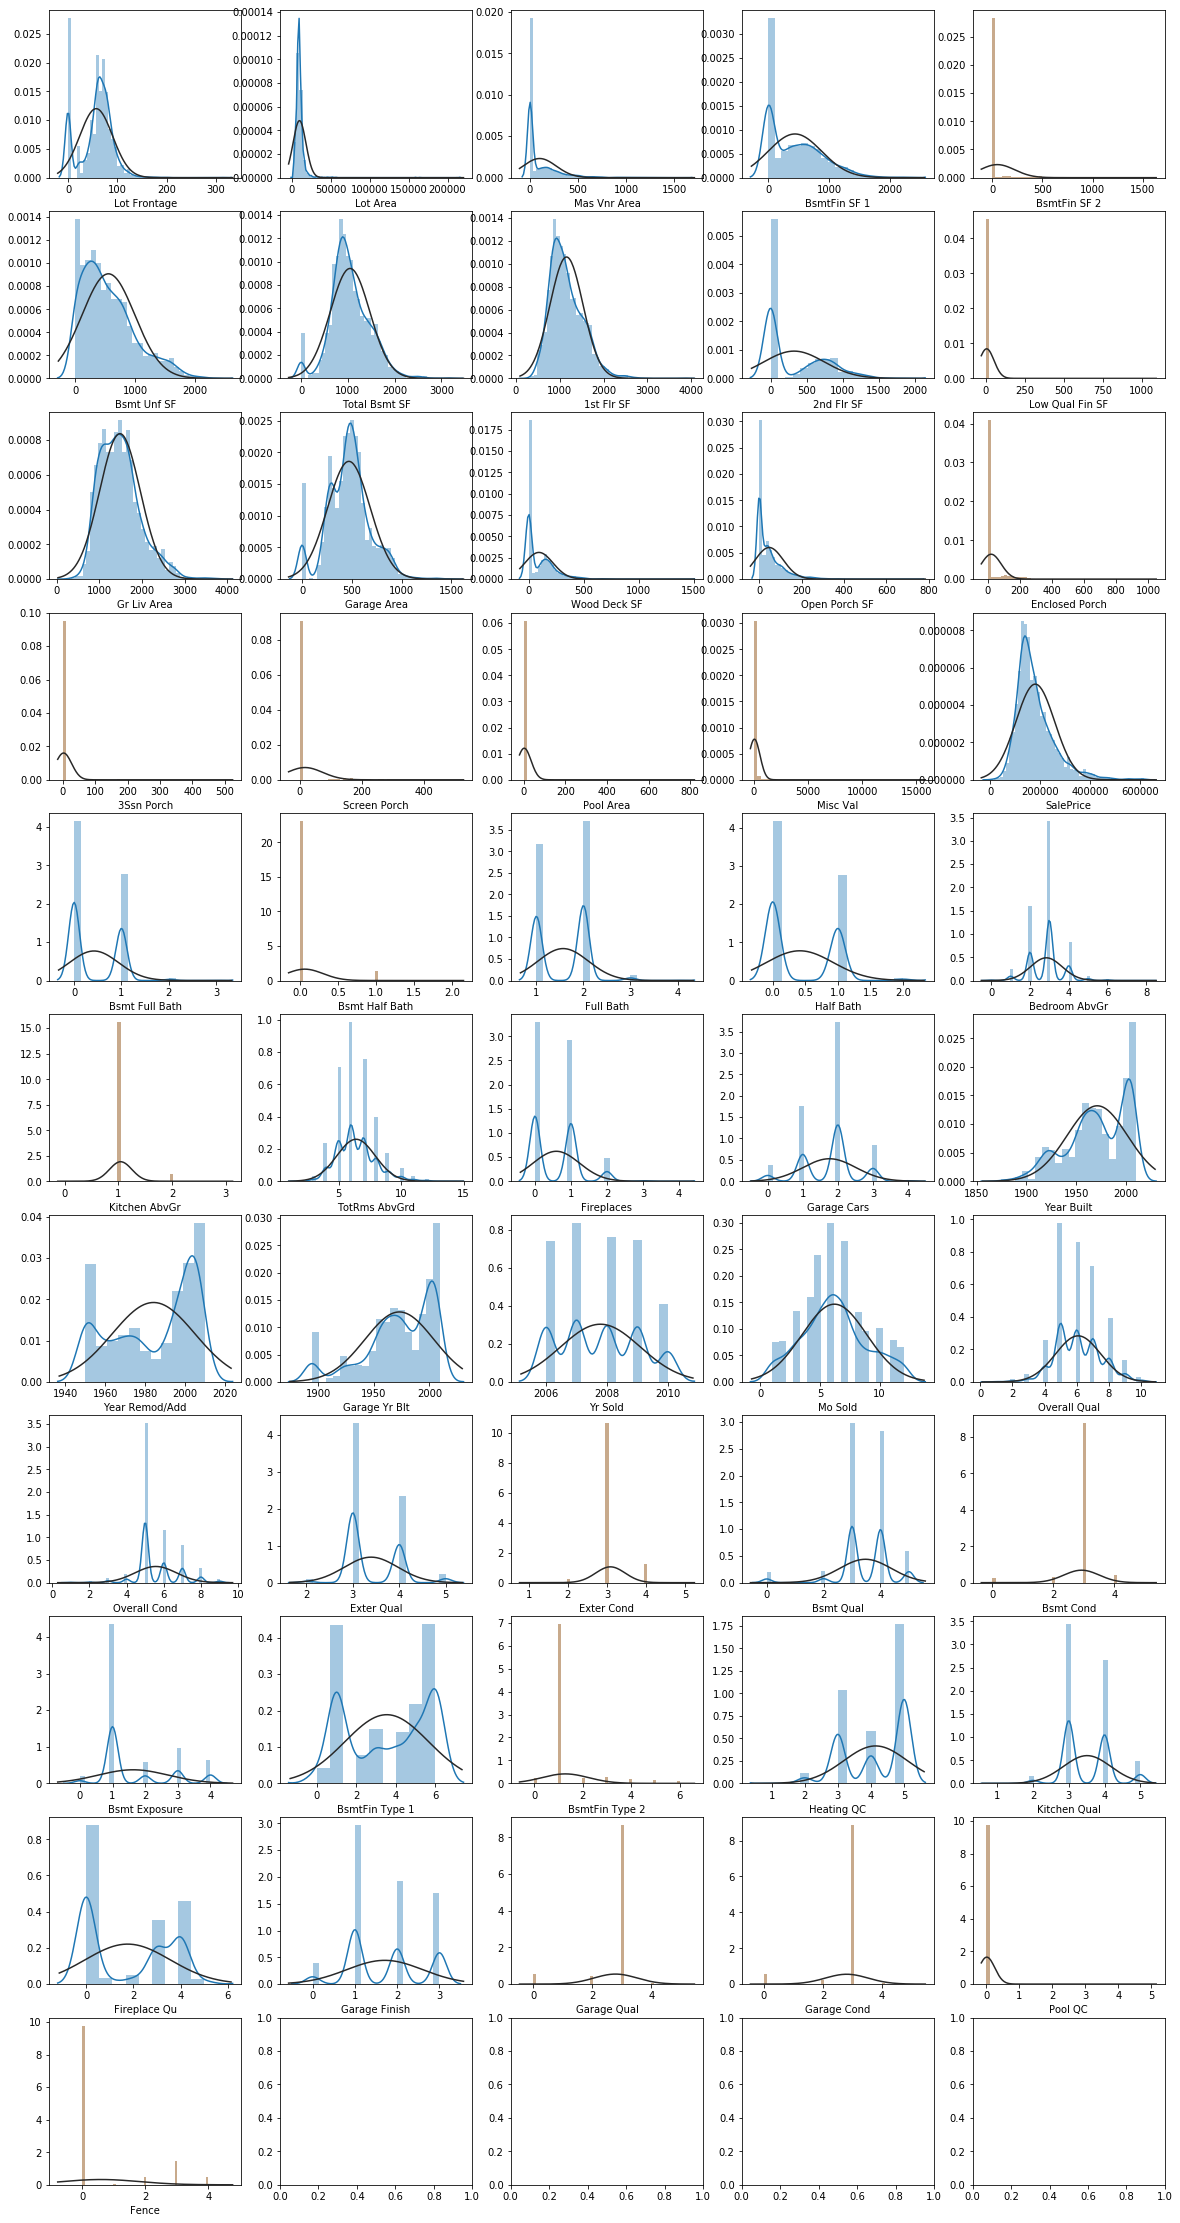

In [62]:
fig, axes = plt.subplots(nrows=11, ncols=5, figsize=(20,40))
for i, col in enumerate(complex_numerical_cols):
    try:
        sns.distplot(df_complex[col], fit=norm, kde=True, ax=axes[int(i/5), i%5])
    except:
        sns.distplot(df_complex[col], fit=norm, kde=False, ax=axes[int(i/5), i%5])
plt.show()

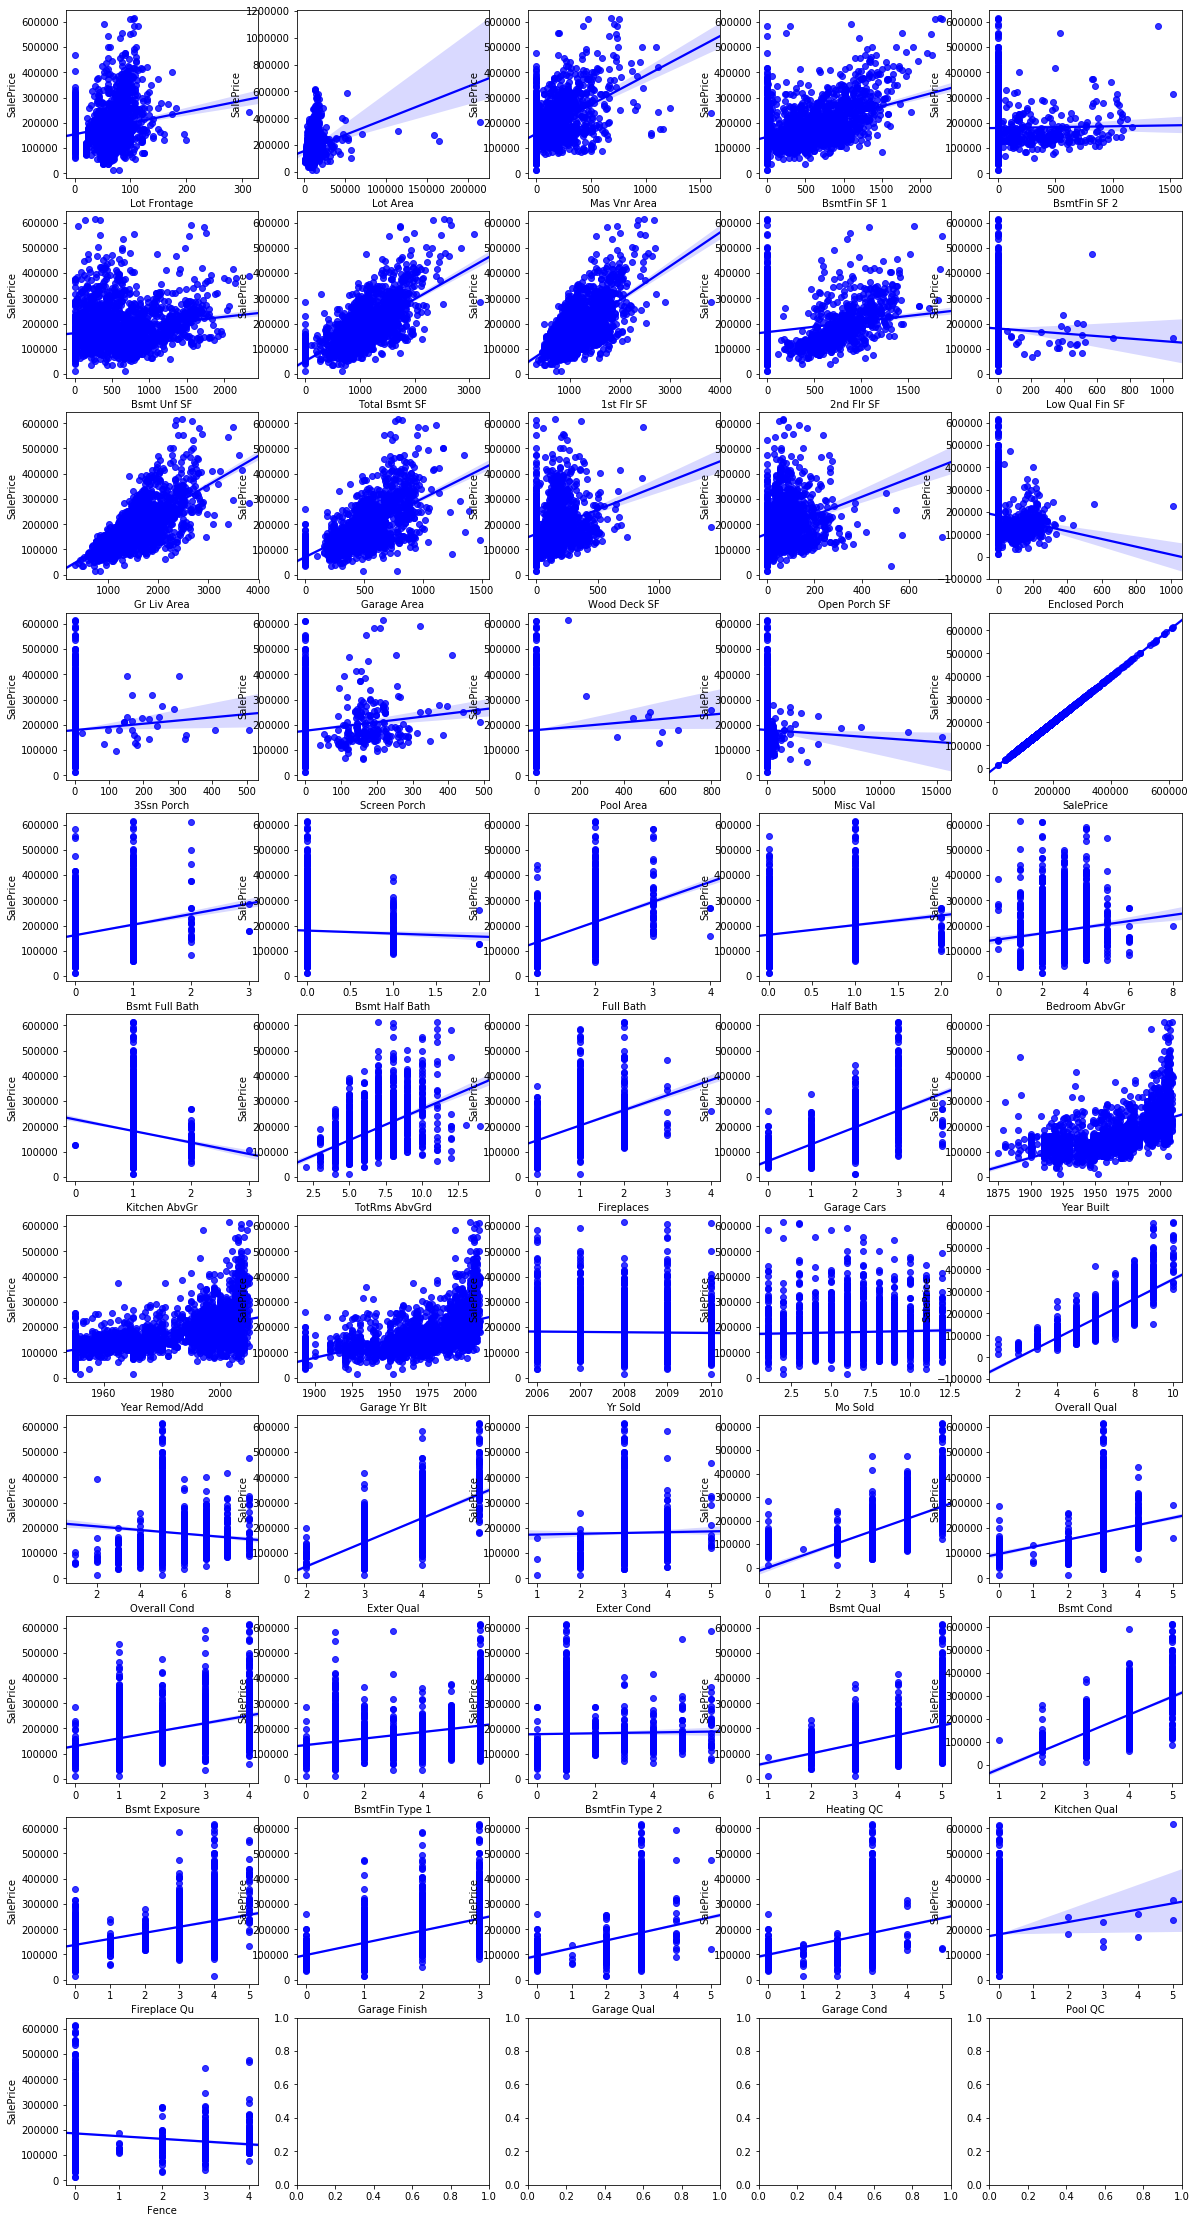

In [63]:
fig, axes = plt.subplots(nrows=11, ncols=5, figsize=(20,40))
for i, col in enumerate(complex_numerical_cols):
    sns.regplot(x=col, y='SalePrice', data=df_complex, ax=axes[int(i/5), i%5], color='b')
plt.show()

In [64]:
# log-transform the data
complex_log_cols = [
    'Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF',
    'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Garage Area',
    'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area',
    'Misc Val','SalePrice', # end of continuous
]
df_complex = df_complex.apply(lambda x: np.log1p(x) if x.name in complex_log_cols else x)

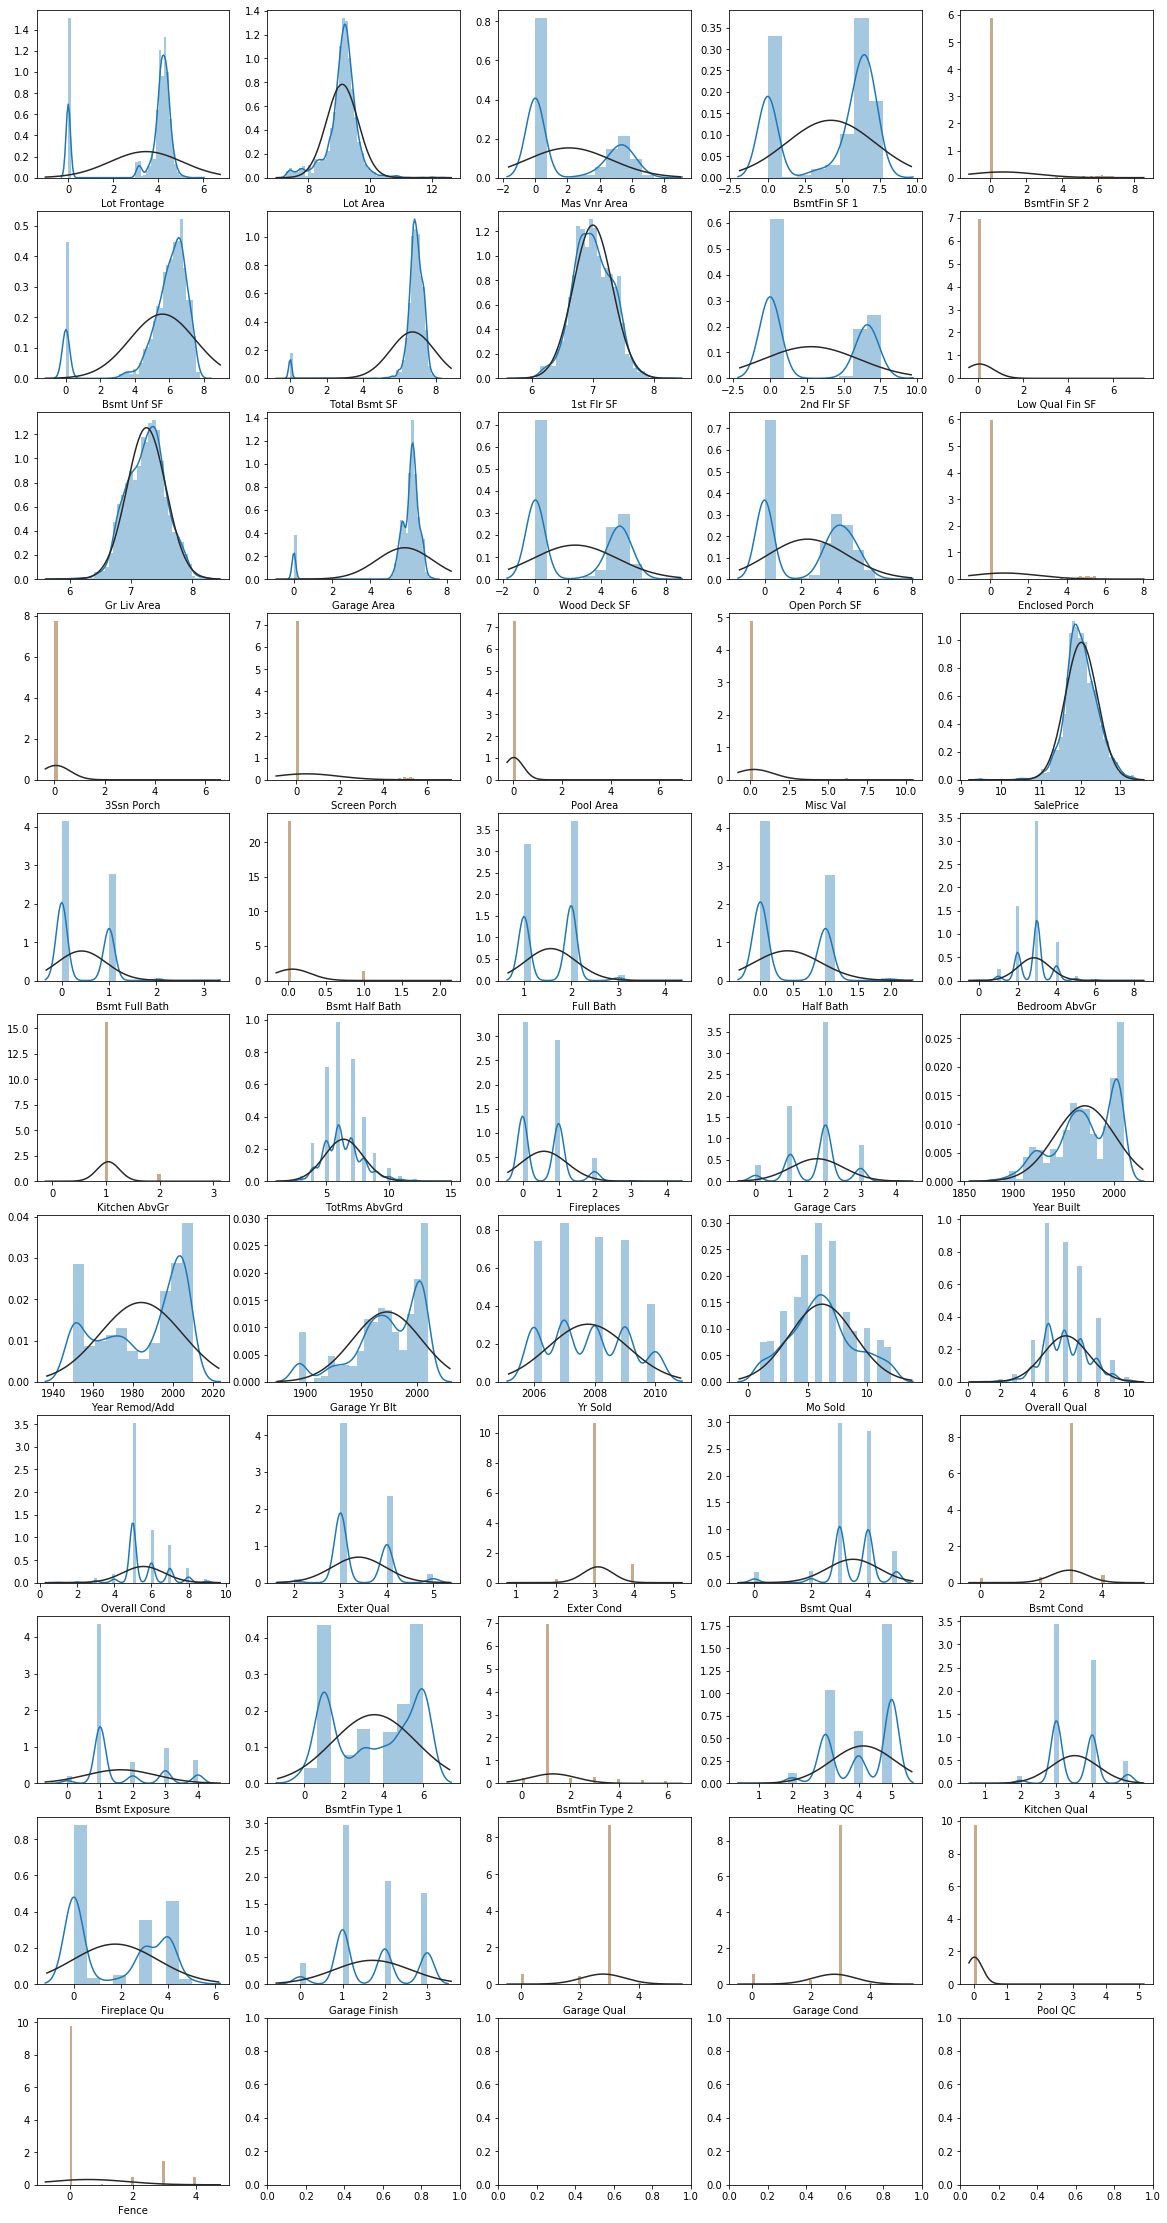

In [65]:
fig, axes = plt.subplots(nrows=11, ncols=5, figsize=(20,40))
for i, col in enumerate(complex_numerical_cols):
    try:
        sns.distplot(df_complex[col], fit=norm, kde=True, ax=axes[int(i/5), i%5])
    except:
        sns.distplot(df_complex[col], fit=norm, kde=False, ax=axes[int(i/5), i%5])
plt.show()

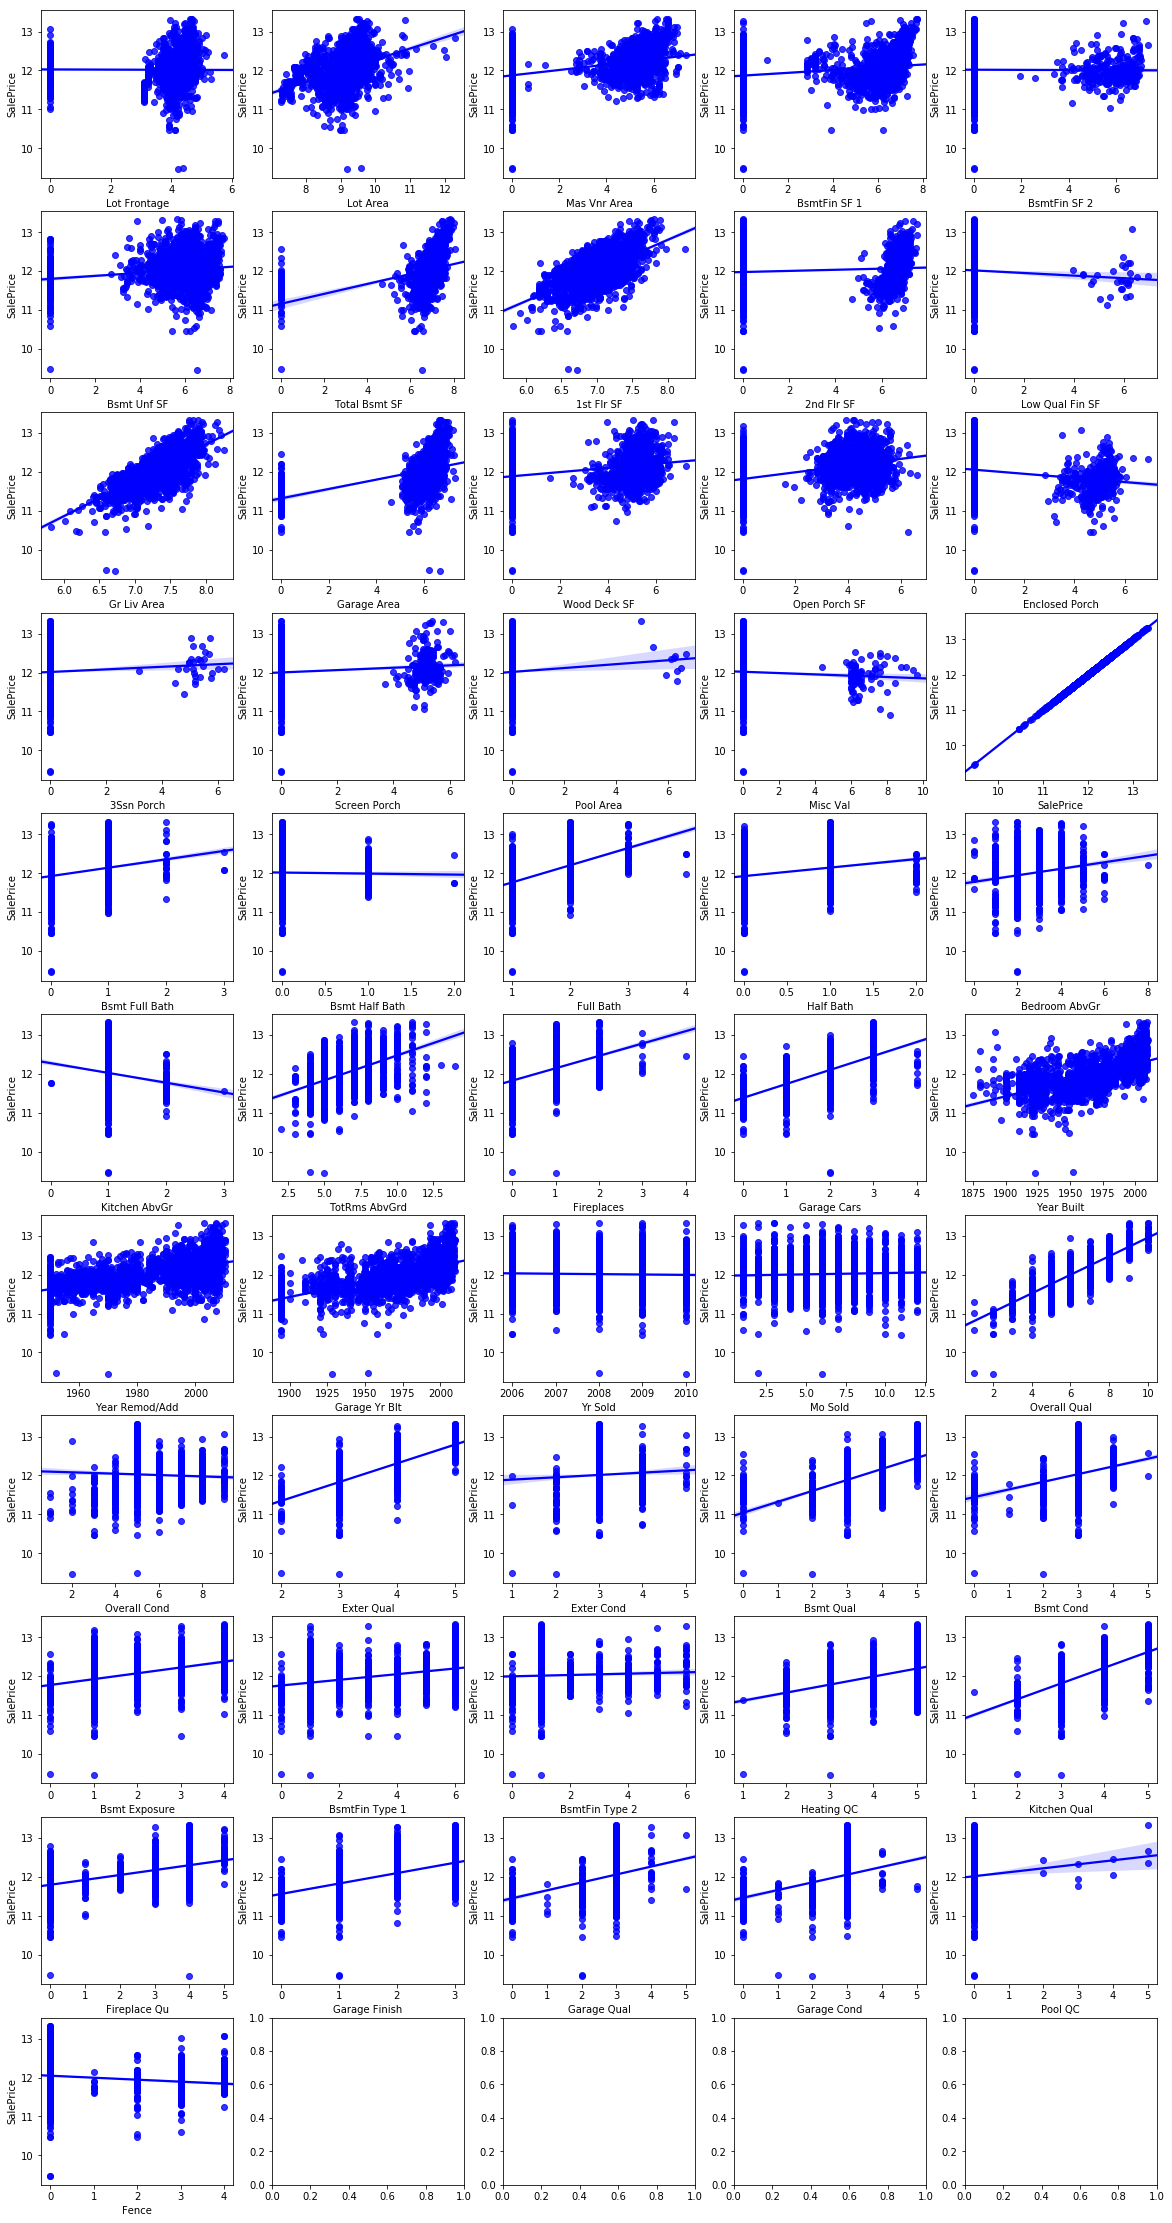

In [66]:
fig, axes = plt.subplots(nrows=11, ncols=5, figsize=(20,40))
for i, col in enumerate(complex_numerical_cols):
    sns.regplot(x=col, y='SalePrice', data=df_complex, ax=axes[int(i/5), i%5], color='b')
plt.show()

In [67]:
# Remove the two obvious outliers
ind_outlier = df_complex[df_complex.SalePrice < 10].index
df_complex.drop(index=ind_outlier, inplace=True)

In [68]:
# Add variables for features that may not exist
df_complex['Lot frontage exists'] = (df_complex['Lot Frontage'] > 0.).astype(int)
df_complex['Masonry exists'] = (df_complex['Mas Vnr Area'] > 0.).astype(int)
df_complex['Basement exists'] = (df_complex['Total Bsmt SF'] > 0.).astype(int)
df_complex['1st Floor exists'] = (df_complex['1st Flr SF'] > 0.).astype(int)
df_complex['2nd Floor exists'] = (df_complex['2nd Flr SF'] > 0.).astype(int)
df_complex['Garage exists'] = (df_complex['Garage Area'] > 0.).astype(int)
df_complex['Wood Deck exists'] = (df_complex['Wood Deck SF'] > 0.).astype(int)
df_complex['Open Porch exists'] = (df_complex['Open Porch SF'] > 0.).astype(int)
df_complex['Enclosed Porch exists'] = (df_complex['Enclosed Porch'] > 0.).astype(int)
df_complex['3Sn Porch exists'] = (df_complex['3Ssn Porch'] > 0.).astype(int)
df_complex['Screen Porch exists'] = (df_complex['Screen Porch'] > 0.).astype(int)
df_complex['Pool exists'] = (df_complex['Pool Area'] > 0.).astype(int)
df_complex['Misc exists'] = (df_complex['Misc Val'] > 0.).astype(int)

In [69]:
X_complex = df_complex.drop(columns=['SalePrice', 'PID']).values
y_complex = df_complex.SalePrice.values

# Split into train-test subsets
X_tr_complex, X_te_complex, y_tr_complex, y_te_complex = train_test_split(X_complex, y_complex, test_size=0.5, random_state=0)

In [70]:
# Rescale the data
scaler = StandardScaler()
X_tr_complex_rescaled = scaler.fit_transform(X_tr_complex)
X_te_complex_rescaled = scaler.transform(X_te_complex)

In [71]:
# There are a couple of values that could be considered outliers so better use Huber loss regression
huber_complex = HuberRegressor()
huber_complex.fit(X_tr_complex_rescaled, y_tr_complex)
y_pred_complex = huber_complex.predict(X_te_complex_rescaled)

In [72]:
# Model evaluation
MSE_huber_complex = MSE(y_te_complex, y_pred_complex)
MAE_huber_complex = MAE(np.exp(y_te_complex), np.exp(y_pred_complex))
R2_huber_complex = R2(y_te_complex, y_pred_complex)
print('R2 huber complex: {:.3f}'.format(R2_huber_complex))
print('MSE huber complex: {:.3f}'.format(MSE_huber_complex))
print('MAE huber complex: {:,.0f}$'.format(MAE_huber_complex))

R2 huber complex: 0.913
MSE huber complex: 0.014
MAE huber complex: 13,972$


# Ridge regression Complex model

In [73]:
gs_complex_results = grid_search(X_complex, y_complex, test_size=0.5, nruns=10, nalpha=100, log_alpha_min=-10, log_alpha_max=10)
gs_complex_results.head()

,alpha,model,run_idx,test_mae,test_mse,test_r2,train_mae,train_mse,train_r2
0,1.000000e-10,"Ridge(alpha=1e-10, copy_X=True, fit_intercept=...",0,15376.158626,0.015652,0.902257,11054.938928,0.007651,0.951803
1,1.592283e-10,"Ridge(alpha=1.592282793341094e-10, copy_X=True...",0,15376.621295,0.015653,0.902248,11054.938928,0.007651,0.951803
2,2.535364e-10,"Ridge(alpha=2.5353644939701164e-10, copy_X=Tru...",0,15377.106242,0.015654,0.902241,11054.938928,0.007651,0.951803
3,4.037017e-10,"Ridge(alpha=4.03701725859655e-10, copy_X=True,...",0,15377.362073,0.015655,0.902237,11054.938928,0.007651,0.951803
4,6.428073e-10,"Ridge(alpha=6.428073117284319e-10, copy_X=True...",0,15377.452232,0.015655,0.902236,11054.938928,0.007651,0.951803


In [74]:
# Group results by alpha value
gb_alpha = gs_complex_results.groupby('alpha')

# Compute test mean scores
mean_te = gb_alpha.test_mae.mean()

# Get entry with the best mean test MSE
best_alpha_complex = mean_te.idxmin()
best_result_complex = gb_alpha.get_group(best_alpha_complex)
ind_best_run = best_result_complex[best_result_complex.test_mae == best_result_complex.test_mae.min()].index
best_run_complex = best_result_complex.loc[ind_best_run, 'run_idx'].values[0]

MSE_Ridge_complex = best_result_complex.test_mse.min()
MAE_Ridge_complex = best_result_complex.test_mae.min()
R2_Ridge_complex = best_result_complex.loc[ind_best_run, 'test_r2'].values[0]

# Print the details
print('Best alpha Ridge Complex: {:.1e}'.format(best_alpha_complex))
print('Best run Ridge Complex: {}'.format(best_run_complex))
print('Best R2 Ridge Complex: {:.3f}'.format(R2_Ridge_complex))
print('Best MSE Ridge Complex: {:.3f}'.format(MSE_Ridge_complex))
print('Best MAE Ridge Complex: {:,.0f}$'.format(MAE_Ridge_complex))

Best alpha Ridge Complex: 3.3e+01
Best run Ridge Complex: 4
Best R2 Ridge Complex: 0.921
Best MSE Ridge Complex: 0.012
Best MAE Ridge Complex: 13,429$


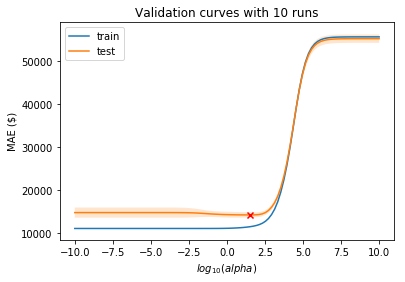

In [75]:
plot_ridge_score(gs_complex_results)

## Predictions

In [76]:
# Select the data from the train dataset
df_complex_te = df_te.copy()
df_complex_te.head()

,PID,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating QC,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Fireplaces,Fireplace Qu,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Wood Deck SF,...,Electrical_Mix,Electrical_SBrkr,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Sev,Functional_Typ,Garage Type_2Types,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_NA,Paved Drive_N,Paved Drive_P,Paved Drive_Y,Misc Feature_Gar2,Misc Feature_NA,Misc Feature_Othr,Misc Feature_Shed,Misc Feature_TenC,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_Abnorml,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
2425,909279080,0.0,11275.0,6,7,1932,1950,480.0,3,3,3,3,2,3,297.0,2,557.0,0.0,854.0,3,1096.0,895.0,0.0,1991.0,0,0,1,1,3,1,3,7,1,4,1977,1,2,432.0,3,2,0.0,...,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2426,907126050,65.0,9757.0,5,7,1994,1994,0.0,3,4,3,3,1,5,755.0,1,0.0,235.0,990.0,5,990.0,0.0,0.0,990.0,1,0,1,0,3,1,3,5,0,0,1995,2,1,440.0,3,3,66.0,...,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2427,528144030,86.0,11065.0,8,5,2006,2006,788.0,4,3,4,3,2,1,0.0,1,0.0,1085.0,1085.0,5,1120.0,850.0,0.0,1970.0,0,0,2,1,3,1,5,8,1,4,2006,3,3,753.0,3,3,177.0,...,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2428,535452060,70.0,7000.0,5,7,1960,2002,45.0,3,3,3,3,1,3,588.0,1,0.0,422.0,1010.0,5,1134.0,0.0,0.0,1134.0,0,0,1,0,2,1,3,6,0,0,1960,2,1,254.0,3,3,0.0,...,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2429,911202100,66.0,8712.0,4,7,1900,1950,0.0,3,3,3,3,2,1,0.0,1,0.0,859.0,859.0,4,859.0,319.0,0.0,1178.0,0,0,1,0,2,1,3,7,0,0,1964,2,1,384.0,3,3,68.0,...,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0


In [77]:
# log-transform data
df_complex_te = df_complex_te.apply(lambda x: np.log1p(x) if x.name in complex_log_cols else x)
df_complex_te.head()

,PID,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating QC,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Fireplaces,Fireplace Qu,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Wood Deck SF,...,Electrical_Mix,Electrical_SBrkr,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Sev,Functional_Typ,Garage Type_2Types,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_NA,Paved Drive_N,Paved Drive_P,Paved Drive_Y,Misc Feature_Gar2,Misc Feature_NA,Misc Feature_Othr,Misc Feature_Shed,Misc Feature_TenC,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_Abnorml,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
2425,909279080,0.000000,9.330432,6,7,1932,1950,6.175867,3,3,3,3,2,3,5.697093,2,6.324359,0.000000,6.751101,3,7.000334,6.797940,0.0,7.596894,0,0,1,1,3,1,3,7,1,4,1977,1,2,6.070738,3,2,0.000000,...,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2426,907126050,4.189655,9.185843,5,7,1994,1994,0.000000,3,4,3,3,1,5,6.628041,1,0.000000,5.463832,6.898715,5,6.898715,0.000000,0.0,6.898715,1,0,1,0,3,1,3,5,0,0,1995,2,1,6.089045,3,3,4.204693,...,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2427,528144030,4.465908,9.311633,8,5,2006,2006,6.670766,4,3,4,3,2,1,0.000000,1,0.000000,6.990257,6.990257,5,7.021976,6.746412,0.0,7.586296,0,0,2,1,3,1,5,8,1,4,2006,3,3,6.625392,3,3,5.181784,...,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2428,535452060,4.262680,8.853808,5,7,1960,2002,3.828641,3,3,3,3,1,3,6.378426,1,0.000000,6.047372,6.918695,5,7.034388,0.000000,0.0,7.034388,0,0,1,0,2,1,3,6,0,0,1960,2,1,5.541264,3,3,0.000000,...,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2429,911202100,4.204693,9.072571,4,7,1900,1950,0.000000,3,3,3,3,2,1,0.000000,1,0.000000,6.756932,6.756932,4,6.756932,5.768321,0.0,7.072422,0,0,1,0,2,1,3,7,0,0,1964,2,1,5.953243,3,3,4.234107,...,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0


In [78]:
# Add variables for features that may not exist
df_complex_te['Lot frontage exists'] = (df_complex_te['Lot Frontage'] > 0.).astype(int)
df_complex_te['Masonry exists'] = (df_complex_te['Mas Vnr Area'] > 0.).astype(int)
df_complex_te['Basement exists'] = (df_complex_te['Total Bsmt SF'] > 0.).astype(int)
df_complex_te['1st Floor exists'] = (df_complex_te['1st Flr SF'] > 0.).astype(int)
df_complex_te['2nd Floor exists'] = (df_complex_te['2nd Flr SF'] > 0.).astype(int)
df_complex_te['Garage exists'] = (df_complex_te['Garage Area'] > 0.).astype(int)
df_complex_te['Wood Deck exists'] = (df_complex_te['Wood Deck SF'] > 0.).astype(int)
df_complex_te['Open Porch exists'] = (df_complex_te['Open Porch SF'] > 0.).astype(int)
df_complex_te['Enclosed Porch exists'] = (df_complex_te['Enclosed Porch'] > 0.).astype(int)
df_complex_te['3Sn Porch exists'] = (df_complex_te['3Ssn Porch'] > 0.).astype(int)
df_complex_te['Screen Porch exists'] = (df_complex_te['Screen Porch'] > 0.).astype(int)
df_complex_te['Pool exists'] = (df_complex_te['Pool Area'] > 0.).astype(int)
df_complex_te['Misc exists'] = (df_complex_te['Misc Val'] > 0.).astype(int)

In [79]:
X_complex_te = df_complex_te.drop(columns='PID').values

In [80]:
# Split into train/test sets
X_tr, _, y_tr, _ = train_test_split(X_complex, y_complex, test_size=0.5, random_state=best_run_complex)
    
# Standardize features
X_tr_rescaled = scaler.fit_transform(X_tr)
X_te_rescaled = scaler.transform(X_complex_te)

ridge = Ridge(alpha=best_alpha_complex)
ridge.fit(X_tr_rescaled, y_tr)
y_complex_pred = np.exp(ridge.predict(X_te_rescaled))

In [81]:
df_complex_te['SalePrice'] = y_complex_pred.astype(int)
df_complex_te.head()

,PID,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating QC,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Fireplaces,Fireplace Qu,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Wood Deck SF,...,Garage Type_CarPort,Garage Type_Detchd,Garage Type_NA,Paved Drive_N,Paved Drive_P,Paved Drive_Y,Misc Feature_Gar2,Misc Feature_NA,Misc Feature_Othr,Misc Feature_Shed,Misc Feature_TenC,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_Abnorml,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial,Lot frontage exists,Masonry exists,Basement exists,1st Floor exists,2nd Floor exists,Garage exists,Wood Deck exists,Open Porch exists,Enclosed Porch exists,3Sn Porch exists,Screen Porch exists,Pool exists,Misc exists,SalePrice
2425,909279080,0.000000,9.330432,6,7,1932,1950,6.175867,3,3,3,3,2,3,5.697093,2,6.324359,0.000000,6.751101,3,7.000334,6.797940,0.0,7.596894,0,0,1,1,3,1,3,7,1,4,1977,1,2,6.070738,3,2,0.000000,...,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,1,1,1,0,0,1,0,0,0,0,212209
2426,907126050,4.189655,9.185843,5,7,1994,1994,0.000000,3,4,3,3,1,5,6.628041,1,0.000000,5.463832,6.898715,5,6.898715,0.000000,0.0,6.898715,1,0,1,0,3,1,3,5,0,0,1995,2,1,6.089045,3,3,4.204693,...,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1,1,0,0,0,1,0,0,161244
2427,528144030,4.465908,9.311633,8,5,2006,2006,6.670766,4,3,4,3,2,1,0.000000,1,0.000000,6.990257,6.990257,5,7.021976,6.746412,0.0,7.586296,0,0,2,1,3,1,5,8,1,4,2006,3,3,6.625392,3,3,5.181784,...,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,296103
2428,535452060,4.262680,8.853808,5,7,1960,2002,3.828641,3,3,3,3,1,3,6.378426,1,0.000000,6.047372,6.918695,5,7.034388,0.000000,0.0,7.034388,0,0,1,0,2,1,3,6,0,0,1960,2,1,5.541264,3,3,0.000000,...,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,0,129567
2429,911202100,4.204693,9.072571,4,7,1900,1950,0.000000,3,3,3,3,2,1,0.000000,1,0.000000,6.756932,6.756932,4,6.756932,5.768321,0.0,7.072422,0,0,1,0,2,1,3,7,0,0,1964,2,1,5.953243,3,3,4.234107,...,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,1,1,1,1,0,1,0,0,0,0,87679


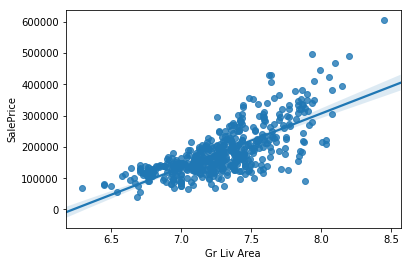

In [82]:
sns.regplot(x='Gr Liv Area', y='SalePrice', data=df_complex_te)
plt.show()

In [83]:
df_complex_te = df_complex_te[['PID', 'SalePrice']]
df_complex_te.to_csv('predictions-complex-model.csv', index=False)

# Compare results

In [84]:
mae_models = [MAE_baseline_median, MAE_huber_simple, MAE_Ridge_inter, MAE_Ridge_complex]

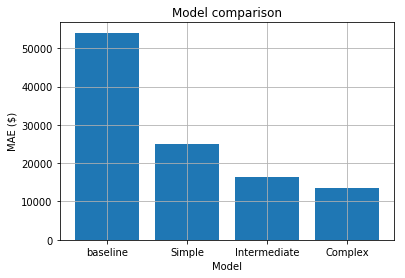

In [85]:
plt.bar([0, 1, 2, 3], mae_models)
plt.xlabel('Model')
plt.ylabel('MAE ($)')
plt.title('Model comparison')
plt.xticks(np.arange(4), ['baseline', 'Simple', 'Intermediate', 'Complex'])
plt.grid()
plt.show()